# **COLAB LOCALDEKİ DOSYA VE KLASÖRLERİ SİLME (DRIVE HARİÇ)**

In [1]:
import os, shutil, glob

skip = {'drive'}  # isterseniz 'sample_data' da ekleyin
for path in glob.glob('/content/*'):
    name = os.path.basename(path)
    if name in skip:
        continue
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)
    else:
        try:
            os.remove(path)
        except FileNotFoundError:
            pass


# **DATASET LABEL DOSYALARINI İNCELEME**

In [ ]:
from glob import glob
from pathlib import Path

DRIVE_ROOT = "/content/drive/MyDrive"
BASE_DIR   = f"{DRIVE_ROOT}/TURKCELL-CodeFem3"
VIDEOS_DIR = f"{BASE_DIR}/Videos_MERL_Shopping_Dataset"
LABELS_DIR = f"{BASE_DIR}/Labels_MERL_Shopping_Dataset"

mp4s = sorted(glob(f"{VIDEOS_DIR}/*.mp4"))
mats = sorted(glob(f"{LABELS_DIR}/*_label.mat"))

video_bases = {Path(p).stem.replace("_crop","") for p in mp4s}
label_bases = {Path(p).stem.replace("_label","") for p in mats}

missing_labels = sorted(video_bases - label_bases)  # videosu var, label yok
missing_videos = sorted(label_bases - video_bases)  # label var, video yok

print("Video sayısı:", len(mp4s))
print("Label sayısı:", len(mats))
print("EKSİK LABEL (ilk 10):", missing_labels[:10])
print("EKSİK VIDEO (ilk 10):", missing_videos[:10])


Video sayısı: 106
Label sayısı: 106
EKSİK LABEL (ilk 10): []
EKSİK VIDEO (ilk 10): []


In [ ]:
import re, numpy as np, scipy.io as sio
from pathlib import Path

def _coerce_kx2(a):
    a = np.array(a)
    if a.size == 0: return np.empty((0,2), int)
    a = np.atleast_2d(a)
    if a.shape[1] != 2 and a.shape[0] == 2: a = a.T
    return a.astype(int)

def load_tlabs(mat_path):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    tl = d['tlabs']
    cells = [tl[i] for i in range(5)] if np.ndim(tl)==1 else list(np.ravel(tl))[:5]
    return [_coerce_kx2(c) for c in cells]

ID2CLASS = {1:"Reach_To_Shelf",2:"Retract_From_Shelf",3:"Hand_In_Shelf",4:"Inspect_Product",5:"Inspect_Shelf"}

stem = "33_1_crop"  # örnek: ekrandaki dosyalardan biri
base = stem.replace("_crop","")
mat_path = f"{LABELS_DIR}/{base}_label.mat"

tlabs = load_tlabs(mat_path)
print("Video:", stem, "-> Label:", Path(mat_path).name)
for i, cname in ID2CLASS.items():
    arr = tlabs[i-1]
    print(f"{cname:18s}: {arr.shape[0]} interval, first5:", arr[:5].tolist())


Video: 33_1_crop -> Label: 33_1_label.mat
Reach_To_Shelf    : 19 interval, first5: [[228, 259], [442, 458], [750, 762], [1105, 1124], [1247, 1269]]
Retract_From_Shelf: 16 interval, first5: [[398, 421], [923, 939], [2438, 2479], [3154, 3185], [3565, 3634]]
Hand_In_Shelf     : 7 interval, first5: [[302, 360], [594, 665], [763, 790], [978, 992], [2763, 2847]]
Inspect_Product   : 6 interval, first5: [[295, 301], [496, 566], [808, 878], [2208, 2379], [3243, 3374]]
Inspect_Shelf     : 7 interval, first5: [[422, 437], [1017, 1104], [1169, 1246], [1314, 1697], [2538, 2711]]


In [ ]:
# Tek video label inceleme + örnek frame çıkarma
!pip -q install scipy opencv-python

import os, cv2, numpy as np, scipy.io as sio
from pathlib import Path

DRIVE_ROOT = "/content/drive/MyDrive"
BASE_DIR   = f"{DRIVE_ROOT}/TURKCELL-CodeFem3"
VIDEOS_DIR = f"{BASE_DIR}/Videos_MERL_Shopping_Dataset"
LABELS_DIR = f"{BASE_DIR}/Labels_MERL_Shopping_Dataset"
OUT_DIR    = f"{BASE_DIR}/MERL_WORK_DRIVE/label_analysis/samples"
os.makedirs(OUT_DIR, exist_ok=True)

FPS = 15
ID2CLASS = {1:"Reach_To_Shelf",2:"Retract_From_Shelf",3:"Hand_In_Shelf",4:"Inspect_Product",5:"Inspect_Shelf"}

def _coerce_kx2(a):
    a = np.array(a);
    if a.size==0: return np.empty((0,2), int)
    a = np.atleast_2d(a)
    if a.shape[1]!=2 and a.shape[0]==2: a=a.T
    return a.astype(int)

def load_tlabs(mp):
    d = sio.loadmat(mp, squeeze_me=True, struct_as_record=False)
    tl = d["tlabs"]
    cells = [tl[i] for i in range(5)] if np.ndim(tl)==1 else list(np.ravel(tl))[:5]
    return [_coerce_kx2(c) for c in cells]

stem = "33_1_crop"  # <- burada başka bir video adıyla değiştirerek oynayabilirsin
base = stem.replace("_crop","")
vpath = f"{VIDEOS_DIR}/{stem}.mp4"
mpath = f"{LABELS_DIR}/{base}_label.mat"

tlabs = load_tlabs(mpath)
max_end = max([arr[:,1].max() if arr.size else 0 for arr in tlabs])
print("Video:", stem, "| tahmini toplam frame (label max_end):", max_end)

# saniyeye çevirip yazdır
for i, cname in ID2CLASS.items():
    arr = tlabs[i-1]
    lens = (arr[:,1]-arr[:,0]+1) if arr.size else np.array([], int)
    secs = lens / FPS
    print(f"{cname:18s}: {len(lens)} interval | ort. {secs.mean():.2f}s (n>0 ise)")
    if arr.size:
        for st,en in arr[:5]:
            L = en-st+1
            print(f"  - [{st},{en}] -> {L} fr ~ {L/FPS:.2f}s")

# overlap kontrolü
occ = np.zeros(max_end+1, np.int16)
for i in range(5):
    for st,en in tlabs[i]:
        st=max(int(st),1); en=int(en)
        if en>=st: occ[st:en+1]+=1
print("Overlap frame sayısı:", int((occ>1).sum()))

# örnek frame kaydet (her sınıftan ilk aralığın ortasından 1 kare)
cap = cv2.VideoCapture(vpath)
def save_frame(index, out_file):
    cap.set(cv2.CAP_PROP_POS_FRAMES, max(index-1,0))
    ok, img = cap.read()
    if ok:
        cv2.imwrite(out_file, img)
        return True
    return False

for i, cname in ID2CLASS.items():
    arr = tlabs[i-1]
    if arr.size:
        mid = int((arr[0,0] + arr[0,1])//2)
        out = f"{OUT_DIR}/{stem}_{cname}_midframe_{mid}.jpg"
        if save_frame(mid, out):
            print("Saved:", out)
cap.release()


Video: 33_1_crop | tahmini toplam frame (label max_end): 3700
Reach_To_Shelf    : 19 interval | ort. 2.07s (n>0 ise)
  - [228,259] -> 32 fr ~ 2.13s
  - [442,458] -> 17 fr ~ 1.13s
  - [750,762] -> 13 fr ~ 0.87s
  - [1105,1124] -> 20 fr ~ 1.33s
  - [1247,1269] -> 23 fr ~ 1.53s
Retract_From_Shelf: 16 interval | ort. 2.80s (n>0 ise)
  - [398,421] -> 24 fr ~ 1.60s
  - [923,939] -> 17 fr ~ 1.13s
  - [2438,2479] -> 42 fr ~ 2.80s
  - [3154,3185] -> 32 fr ~ 2.13s
  - [3565,3634] -> 70 fr ~ 4.67s
Hand_In_Shelf     : 7 interval | ort. 2.99s (n>0 ise)
  - [302,360] -> 59 fr ~ 3.93s
  - [594,665] -> 72 fr ~ 4.80s
  - [763,790] -> 28 fr ~ 1.87s
  - [978,992] -> 15 fr ~ 1.00s
  - [2763,2847] -> 85 fr ~ 5.67s
Inspect_Product   : 6 interval | ort. 5.37s (n>0 ise)
  - [295,301] -> 7 fr ~ 0.47s
  - [496,566] -> 71 fr ~ 4.73s
  - [808,878] -> 71 fr ~ 4.73s
  - [2208,2379] -> 172 fr ~ 11.47s
  - [3243,3374] -> 132 fr ~ 8.80s
Inspect_Shelf     : 7 interval | ort. 9.53s (n>0 ise)
  - [422,437] -> 16 fr ~ 1.0

# **SPLIT THE DATASET: TRAIN, VALIDATION, TEST**

**CREAT THE DATASET IN DRIVE**

In [2]:
# ============================
# A) PREP — Build on Drive (SAFE SAVE, BG=action dışı)
# ============================
!pip -q install scipy opencv-python tqdm

import os, re, json, subprocess, shutil, time, random, hashlib
from glob import glob
from pathlib import Path
import numpy as np
import scipy.io as sio
from tqdm import tqdm
import cv2

# --- Drive ---
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception:
    drive.mount('/content/drive', force_remount=True)

# --- Paths (HEPSİ DRIVE) ---
DRIVE_ROOT = "/content/drive/MyDrive"
BASE_DIR   = f"{DRIVE_ROOT}/TURKCELL-CodeFem3"
VIDEOS_DIR = f"{BASE_DIR}/Videos_MERL_Shopping_Dataset"
LABELS_DIR = f"{BASE_DIR}/Labels_MERL_Shopping_Dataset"

WORK_DRIVE   = f"{BASE_DIR}/MERL_WORK_DRIVE"   # tüm çalışma Drive'da
DATASET_CLS  = f"{WORK_DRIVE}/dataset_cls"     # YOLO-CLS klasör yapısı (Drive)
TMP_FRAMES   = "/content/tmp_frames"           # geçici (local) — her video bitince silinir
LOG_DIR      = f"{WORK_DRIVE}/prep_logs"
os.makedirs(WORK_DRIVE,  exist_ok=True)
os.makedirs(DATASET_CLS, exist_ok=True)
os.makedirs(TMP_FRAMES,  exist_ok=True)
os.makedirs(LOG_DIR,     exist_ok=True)

# --- Parametreler ---
FPS = 15
FRAME_STEP = 2               # her 2 karede 1
BG_KEEP_EVERY = 6            # BG seyrelti (action dışındaki karelerde her 6'da 1)
BACKFILL_BG_IF_EMPTY = False # BG'yi artık gerçekten üreteceğiz

# SAFE SAVE ayarları
RETRIES = 3
VERIFY_STRATEGY = 'size'     # 'size' | 'md5' | 'none'
MD5_SAMPLE_RATIO = 0.02

ID2CLASS = {
    0: "Background",
    1: "Reach_To_Shelf",
    2: "Retract_From_Shelf",
    3: "Hand_In_Shelf",
    4: "Inspect_Product",
    5: "Inspect_Shelf",
}
CLASSES = list(ID2CLASS.values())

# Sabit subject split
TRAIN_SUBJ = set(range(1, 21))
VAL_SUBJ   = set(range(21, 27))
TEST_SUBJ  = set(range(27, 42))

# klasörleri hazırla
for split in ["train","val","test"]:
    for cname in CLASSES:
        os.makedirs(os.path.join(DATASET_CLS, split, cname), exist_ok=True)

def ensure_ffmpeg():
    try:
        subprocess.run(["ffmpeg","-version"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except Exception:
        subprocess.run(["apt","-y","install","ffmpeg"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

def _coerce_kx2(a):
    a = np.array(a)
    if a.size == 0: return np.empty((0,2), dtype=int)
    a = np.atleast_2d(a)
    if a.shape[1] != 2 and a.shape[0] == 2: a = a.T
    if a.shape[1] != 2: raise ValueError(f"Expected Kx2, got {a.shape}")
    return a.astype(int)

def load_tlabs(mat_path):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    if 'tlabs' not in d: raise KeyError(f"'tlabs' not in {mat_path}")
    tl = d['tlabs']
    if np.ndim(tl) == 1 and len(tl) == 5: cells = [tl[i] for i in range(5)]
    elif isinstance(tl, np.ndarray) and tl.shape == (1,5): cells = [tl[0,i] for i in range(5)]
    elif isinstance(tl, np.ndarray) and tl.shape == (5,1): cells = [tl[i,0] for i in range(5)]
    else: tl_flat = np.ravel(tl); assert tl_flat.size >= 5; cells = [tl_flat[i] for i in range(5)]
    return [_coerce_kx2(c) for c in cells]

def parse_subject_session(stem):
    m = re.match(r"^(\d+)_([0-9]+)_crop$", stem)
    return (int(m.group(1)), int(m.group(2))) if m else (None, None)

def split_of_subject(subj):
    if subj in TRAIN_SUBJ: return "train"
    if subj in VAL_SUBJ:   return "val"
    if subj in TEST_SUBJ:  return "test"
    return "train"

def extract_frames_temp(video_path, tmp_out_dir):
    os.makedirs(tmp_out_dir, exist_ok=True)
    cmd = ["ffmpeg","-y","-i",video_path,"-vf",f"fps={FPS}","-q:v","2",
           os.path.join(tmp_out_dir,"frame_%06d.jpg")]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def dataset_has_video(root, stem):
    pat = f"{stem}_f*.jpg"
    for split in ["train","val","test"]:
        for cname in CLASSES:
            if glob(os.path.join(root, split, cname, pat)):
                return True
    return False

# ---- SAFE COPY to Drive ----
def _md5(path, chunk=1024*1024):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for b in iter(lambda: f.read(chunk), b""): h.update(b)
    return h.hexdigest()

def _fsync_dir(dirpath):
    try:
        fd = os.open(dirpath, os.O_DIRECTORY)
        os.fsync(fd); os.close(fd)
    except: pass

def safe_copy_to_drive(src, dst, verify='size', retries=RETRIES):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    tmp = dst + ".tmp"
    src_size = os.path.getsize(src)
    src_md5  = None
    for attempt in range(1, retries+1):
        try:
            shutil.copy2(src, tmp)
            with open(tmp, "rb") as f: os.fsync(f.fileno())
            os.replace(tmp, dst); _fsync_dir(os.path.dirname(dst))
            if verify == 'none': return True
            if verify == 'size' and os.path.getsize(dst) == src_size: return True
            if verify == 'md5':
                if src_md5 is None: src_md5 = _md5(src)
                if _md5(dst) == src_md5: return True
            print(f"Verify failed ({verify}) for {os.path.basename(dst)} (attempt {attempt})")
        except Exception as e:
            print(f"Copy error for {os.path.basename(dst)} (attempt {attempt}): {e}")
        try:
            if os.path.exists(tmp): os.remove(tmp)
        except: pass
        time.sleep(0.8)
    raise RuntimeError(f"FAILED to copy {src} -> {dst} after {retries} retries")

# --- Çalıştır ---
assert os.path.isdir(VIDEOS_DIR), f"Video klasörü yok: {VIDEOS_DIR}"
assert os.path.isdir(LABELS_DIR), f"Label klasörü yok: {LABELS_DIR}"
ensure_ffmpeg()

mp4s = sorted(glob(os.path.join(VIDEOS_DIR, "*.mp4")))
mats = {Path(p).stem.replace("_label",""): p for p in glob(os.path.join(LABELS_DIR, "*_label.mat"))}
print(f"Bulunan video: {len(mp4s)} | label: {len(mats)}")

ts_run = time.strftime("%Y%m%d_%H%M%S")
manifest = {
    "run_ts": ts_run,
    "params": {"FPS": FPS, "FRAME_STEP": FRAME_STEP, "BG_KEEP_EVERY": BG_KEEP_EVERY,
               "VERIFY_STRATEGY": VERIFY_STRATEGY},
    "videos": []
}

global_counts = {sp:{c:0 for c in CLASSES} for sp in ["train","val","test"]}

for vpath in tqdm(mp4s, desc="PREP (SAFE): build dataset_cls with explicit BG -> Drive"):
    stem = Path(vpath).stem         # "12_3_crop"
    base = stem.replace("_crop","") # "12_3"
    if base not in mats:
        continue
    if dataset_has_video(DATASET_CLS, stem):
        continue

    subj,_ = parse_subject_session(stem)
    split = split_of_subject(subj)

    # 1) 15 FPS kare çıkar (LOCAL tmp)
    tmp_dir = os.path.join(TMP_FRAMES, stem)
    if os.path.exists(tmp_dir): shutil.rmtree(tmp_dir, ignore_errors=True)
    extract_frames_temp(vpath, tmp_dir)

    frames = sorted(glob(os.path.join(tmp_dir, "frame_*.jpg")))
    if not frames:
        shutil.rmtree(tmp_dir, ignore_errors=True)
        continue
    num_frames = len(frames)

    # 2) label aralıklarını oku -> action-union maskesi + sınıf id ataması
    tlabs = load_tlabs(mats[base])  # 5 sınıf
    occ = np.zeros(num_frames + 1, dtype=np.uint8)   # 1..N
    labels = np.zeros(num_frames + 1, dtype=np.int16)

    # action-union
    for cls_idx in range(1, 6):
        arr = tlabs[cls_idx-1]
        if arr.size == 0: continue
        for (st, en) in arr:
            st = max(int(st), 1); en = min(int(en), num_frames)
            if en >= st: occ[st:en+1] = 1

    # sınıf id
    for cls_idx in range(1, 6):
        arr = tlabs[cls_idx-1]
        if arr.size == 0: continue
        for (st, en) in arr:
            st = max(int(st), 1); en = min(int(en), num_frames)
            if en >= st: labels[st:en+1] = cls_idx

    # 3) kopyalama: action -> sınıfına; action dışı -> Background (seyreltilmiş)
    kept_counts = {c:0 for c in CLASSES}
    bg_stride_counter = 0

    for i, f in enumerate(frames, start=1):
        if (i-1) % FRAME_STEP != 0:
            continue

        if occ[i] == 1:
            cls_id = int(labels[i])
            cname = ID2CLASS.get(cls_id, "Background")
            dst = os.path.join(DATASET_CLS, split, cname, f"{stem}_f{i:06d}.jpg")
            safe_copy_to_drive(f, dst, verify=VERIFY_STRATEGY)
            kept_counts[cname] += 1
            global_counts[split][cname] += 1
        else:
            bg_stride_counter += 1
            if (bg_stride_counter % BG_KEEP_EVERY) != 0:
                continue
            dst = os.path.join(DATASET_CLS, split, "Background", f"{stem}_f{i:06d}.jpg")
            safe_copy_to_drive(f, dst, verify=VERIFY_STRATEGY)
            kept_counts["Background"] += 1
            global_counts[split]["Background"] += 1

    # 4) tmp temizle
    shutil.rmtree(tmp_dir, ignore_errors=True)

    # 5) manifest
    manifest["videos"].append({"stem": stem, "split": split, **kept_counts})
    man_tmp = f"/content/prep_manifest_{ts_run}.json"
    with open(man_tmp, "w") as f: json.dump(manifest, f, indent=2, ensure_ascii=False)
    safe_copy_to_drive(man_tmp, os.path.join(LOG_DIR, f"prep_manifest_{ts_run}.json"), verify='size')
    try: os.remove(man_tmp)
    except: pass

    print(f"{stem} -> {split} | BG:{kept_counts['Background']} "
          f"R:{kept_counts['Reach_To_Shelf']} Rt:{kept_counts['Retract_From_Shelf']} "
          f"H:{kept_counts['Hand_In_Shelf']} IP:{kept_counts['Inspect_Product']} IS:{kept_counts['Inspect_Shelf']}")

# classes.json -> Drive (SAFE)
classes_json_tmp = "/content/classes.json"
with open(classes_json_tmp, "w") as fh:
    json.dump(ID2CLASS, fh, indent=2, ensure_ascii=False)
safe_copy_to_drive(classes_json_tmp, os.path.join(DATASET_CLS, "classes.json"), verify='size')
try: os.remove(classes_json_tmp)
except: pass

# Özet sayım (Drive üzerindeki gerçek dosya sayısı)
def count_split(root, sp):
    return {c: len(glob(os.path.join(root, sp, c, '*.jpg'))) for c in CLASSES}

print("\nPREP (SAFE) tamam ✅  Drive dataset path:", DATASET_CLS)
for sp in ["train","val","test"]:
    print(sp, count_split(DATASET_CLS, sp), "|", os.path.join(DATASET_CLS, sp))

print("\nGlobal counts (accumulated while writing):")
for sp in ["train","val","test"]:
    print(sp, global_counts[sp])

# (Opsiyonel) disk cache flush
!sync


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.8 MB/s eta 0:00:00
Mounted at /content/drive
Bulunan video: 106 | label: 106


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   2%|▏         | 2/106 [00:14<12:31,  7.23s/it]

10_2_crop -> train | BG:40 R:119 Rt:145 H:174 IP:195 IS:192


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   3%|▎         | 3/106 [00:31<19:10, 11.17s/it]

10_3_crop -> train | BG:70 R:158 Rt:114 H:50 IP:109 IS:200


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   4%|▍         | 4/106 [00:42<18:57, 11.15s/it]

11_1_crop -> train | BG:51 R:131 Rt:118 H:38 IP:185 IS:157


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   5%|▍         | 5/106 [01:02<23:55, 14.21s/it]

11_2_crop -> train | BG:43 R:175 Rt:167 H:161 IP:146 IS:285


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   6%|▌         | 6/106 [01:18<24:56, 14.96s/it]

11_3_crop -> train | BG:24 R:88 Rt:168 H:154 IP:0 IS:394


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   7%|▋         | 7/106 [01:32<23:54, 14.49s/it]

12_1_crop -> train | BG:44 R:130 Rt:159 H:37 IP:260 IS:92


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   8%|▊         | 8/106 [01:56<28:57, 17.73s/it]

12_2_crop -> train | BG:48 R:198 Rt:217 H:53 IP:169 IS:126


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   8%|▊         | 9/106 [02:16<29:40, 18.36s/it]

12_3_crop -> train | BG:40 R:124 Rt:138 H:77 IP:150 IS:242


PREP (SAFE): build dataset_cls with explicit BG -> Drive:   9%|▉         | 10/106 [02:37<30:43, 19.20s/it]

13_1_crop -> train | BG:71 R:61 Rt:83 H:19 IP:290 IS:118


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  10%|█         | 11/106 [03:16<39:58, 25.24s/it]

13_2_crop -> train | BG:71 R:84 Rt:97 H:25 IP:512 IS:16


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  11%|█▏        | 12/106 [03:45<40:56, 26.13s/it]

13_3_crop -> train | BG:37 R:173 Rt:203 H:0 IP:273 IS:147


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  12%|█▏        | 13/106 [04:14<42:00, 27.10s/it]

14_1_crop -> train | BG:68 R:72 Rt:75 H:13 IP:159 IS:388


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  13%|█▎        | 14/106 [04:54<47:44, 31.14s/it]

14_2_crop -> train | BG:29 R:50 Rt:74 H:31 IP:471 IS:250


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  14%|█▍        | 15/106 [05:38<52:53, 34.88s/it]

14_3_crop -> train | BG:34 R:138 Rt:134 H:10 IP:178 IS:348


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  15%|█▌        | 16/106 [06:44<1:06:20, 44.23s/it]

15_1_crop -> train | BG:19 R:90 Rt:67 H:18 IP:119 IS:564


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  16%|█▌        | 17/106 [07:55<1:17:37, 52.33s/it]

15_2_crop -> train | BG:23 R:170 Rt:88 H:124 IP:459 IS:7


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  17%|█▋        | 18/106 [08:49<1:17:38, 52.94s/it]

15_3_crop -> train | BG:31 R:202 Rt:250 H:84 IP:208 IS:51


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  18%|█▊        | 19/106 [09:58<1:23:43, 57.75s/it]

16_1_crop -> train | BG:52 R:126 Rt:130 H:120 IP:160 IS:219


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  19%|█▉        | 20/106 [11:06<1:26:50, 60.58s/it]

16_2_crop -> train | BG:29 R:140 Rt:81 H:59 IP:196 IS:426


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  20%|█▉        | 21/106 [13:19<1:56:38, 82.34s/it]

16_3_crop -> train | BG:46 R:107 Rt:138 H:129 IP:400 IS:118


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  21%|██        | 22/106 [15:06<2:05:57, 89.97s/it]

17_1_crop -> train | BG:28 R:123 Rt:106 H:54 IP:305 IS:229


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  22%|██▏       | 23/106 [17:46<2:33:13, 110.76s/it]

17_2_crop -> train | BG:32 R:182 Rt:95 H:78 IP:410 IS:79


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  23%|██▎       | 24/106 [19:41<2:33:19, 112.19s/it]

17_3_crop -> train | BG:34 R:228 Rt:265 H:101 IP:26 IS:302


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  24%|██▎       | 25/106 [21:44<2:35:39, 115.31s/it]

18_1_crop -> train | BG:26 R:258 Rt:189 H:55 IP:236 IS:76


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  25%|██▍       | 26/106 [24:14<2:47:34, 125.68s/it]

18_2_crop -> train | BG:19 R:182 Rt:163 H:86 IP:172 IS:231


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  25%|██▌       | 27/106 [25:49<2:33:28, 116.56s/it]

18_3_crop -> train | BG:37 R:78 Rt:118 H:225 IP:114 IS:251


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  26%|██▋       | 28/106 [29:52<3:20:51, 154.50s/it]

19_1_crop -> train | BG:32 R:124 Rt:126 H:115 IP:0 IS:420


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  27%|██▋       | 29/106 [32:45<3:25:36, 160.21s/it]

19_2_crop -> train | BG:34 R:175 Rt:162 H:116 IP:28 IS:312


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  28%|██▊       | 30/106 [35:50<3:31:59, 167.36s/it]

19_3_crop -> train | BG:25 R:262 Rt:276 H:113 IP:0 IS:178


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  29%|██▉       | 31/106 [37:47<3:10:21, 152.29s/it]

1_1_crop -> train | BG:56 R:132 Rt:113 H:95 IP:208 IS:95


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  30%|███       | 32/106 [39:59<3:00:25, 146.30s/it]

1_2_crop -> train | BG:22 R:140 Rt:125 H:158 IP:319 IS:94


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  31%|███       | 33/106 [44:43<3:48:20, 187.68s/it]

1_3_crop -> train | BG:55 R:161 Rt:148 H:40 IP:460 IS:187


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  32%|███▏      | 34/106 [46:37<3:18:39, 165.55s/it]

20_1_crop -> train | BG:41 R:132 Rt:132 H:56 IP:21 IS:440


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  33%|███▎      | 35/106 [50:59<3:50:13, 194.56s/it]

20_2_crop -> train | BG:45 R:117 Rt:97 H:174 IP:319 IS:306


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  34%|███▍      | 36/106 [56:59<4:44:52, 244.17s/it]

20_3_crop -> train | BG:40 R:184 Rt:193 H:27 IP:290 IS:279


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  35%|███▍      | 37/106 [58:04<3:38:50, 190.30s/it]

21_1_crop -> val | BG:67 R:95 Rt:139 H:0 IP:197 IS:213


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  36%|███▌      | 38/106 [59:12<2:54:13, 153.73s/it]

21_2_crop -> val | BG:33 R:112 Rt:143 H:131 IP:28 IS:414


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  37%|███▋      | 39/106 [1:00:11<2:19:47, 125.19s/it]

21_3_crop -> val | BG:38 R:109 Rt:135 H:5 IP:263 IS:347


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  38%|███▊      | 40/106 [1:00:32<1:43:12, 93.82s/it] 

22_1_crop -> val | BG:46 R:79 Rt:94 H:14 IP:295 IS:337


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  39%|███▊      | 41/106 [1:00:53<1:18:06, 72.10s/it]

22_2_crop -> val | BG:23 R:59 Rt:117 H:0 IP:449 IS:305


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  40%|███▉      | 42/106 [1:01:15<1:00:52, 57.07s/it]

22_3_crop -> val | BG:41 R:104 Rt:149 H:93 IP:169 IS:286


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  41%|████      | 43/106 [1:01:36<48:29, 46.18s/it]  

23_1_crop -> val | BG:49 R:99 Rt:119 H:102 IP:285 IS:143


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  42%|████▏     | 44/106 [1:02:02<41:27, 40.12s/it]

23_2_crop -> val | BG:67 R:141 Rt:151 H:21 IP:383 IS:218


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  42%|████▏     | 45/106 [1:02:43<41:15, 40.58s/it]

23_3_crop -> val | BG:60 R:182 Rt:179 H:142 IP:90 IS:586


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  43%|████▎     | 46/106 [1:03:18<38:55, 38.92s/it]

24_1_crop -> val | BG:38 R:81 Rt:85 H:60 IP:271 IS:329


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  44%|████▍     | 47/106 [1:04:13<43:01, 43.76s/it]

24_2_crop -> val | BG:22 R:223 Rt:153 H:56 IP:325 IS:284


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  45%|████▌     | 48/106 [1:05:08<45:19, 46.89s/it]

24_3_crop -> val | BG:24 R:153 Rt:165 H:31 IP:158 IS:570


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  46%|████▌     | 49/106 [1:05:54<44:15, 46.60s/it]

25_1_crop -> val | BG:49 R:105 Rt:112 H:46 IP:164 IS:363


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  47%|████▋     | 50/106 [1:06:37<42:29, 45.53s/it]

25_2_crop -> val | BG:41 R:151 Rt:143 H:98 IP:302 IS:171


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  48%|████▊     | 51/106 [1:07:50<49:28, 53.97s/it]

25_3_crop -> val | BG:47 R:114 Rt:177 H:112 IP:61 IS:270


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  49%|████▉     | 52/106 [1:08:43<48:18, 53.68s/it]

26_1_crop -> val | BG:59 R:101 Rt:109 H:90 IP:201 IS:267


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  50%|█████     | 53/106 [1:10:02<54:09, 61.31s/it]

26_2_crop -> val | BG:21 R:207 Rt:171 H:73 IP:444 IS:169


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  51%|█████     | 54/106 [1:10:53<50:20, 58.09s/it]

26_3_crop -> val | BG:38 R:121 Rt:119 H:44 IP:149 IS:358


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  52%|█████▏    | 55/106 [1:11:06<37:57, 44.66s/it]

27_1_crop -> test | BG:50 R:98 Rt:94 H:0 IP:320 IS:202


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  53%|█████▎    | 56/106 [1:11:23<30:07, 36.16s/it]

27_2_crop -> test | BG:27 R:137 Rt:129 H:13 IP:268 IS:311


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  54%|█████▍    | 57/106 [1:11:36<23:52, 29.24s/it]

27_3_crop -> test | BG:56 R:118 Rt:105 H:138 IP:138 IS:178


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  55%|█████▍    | 58/106 [1:11:51<19:57, 24.94s/it]

28_1_crop -> test | BG:32 R:83 Rt:110 H:105 IP:199 IS:314


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  56%|█████▌    | 59/106 [1:12:09<17:54, 22.87s/it]

28_2_crop -> test | BG:48 R:109 Rt:146 H:86 IP:194 IS:270


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  57%|█████▋    | 60/106 [1:12:24<15:42, 20.48s/it]

28_3_crop -> test | BG:40 R:128 Rt:131 H:149 IP:112 IS:229


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  58%|█████▊    | 61/106 [1:12:46<15:54, 21.20s/it]

29_1_crop -> test | BG:51 R:67 Rt:76 H:122 IP:0 IS:544


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  58%|█████▊    | 62/106 [1:13:10<16:10, 22.06s/it]

29_2_crop -> test | BG:47 R:115 Rt:114 H:126 IP:363 IS:138


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  59%|█████▉    | 63/106 [1:13:40<17:29, 24.40s/it]

29_3_crop -> test | BG:69 R:89 Rt:63 H:656 IP:44 IS:169


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  60%|██████    | 64/106 [1:16:05<42:18, 60.43s/it]

2_1_crop -> train | BG:40 R:183 Rt:172 H:170 IP:22 IS:162


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  61%|██████▏   | 65/106 [1:20:03<1:17:38, 113.63s/it]

2_2_crop -> train | BG:35 R:140 Rt:121 H:163 IP:0 IS:308


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  62%|██████▏   | 66/106 [1:23:23<1:33:02, 139.57s/it]

2_3_crop -> train | BG:19 R:192 Rt:252 H:216 IP:0 IS:122


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  63%|██████▎   | 67/106 [1:24:39<1:18:25, 120.64s/it]

30_1_crop -> test | BG:36 R:148 Rt:153 H:158 IP:343 IS:69


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  64%|██████▍   | 68/106 [1:25:27<1:02:32, 98.75s/it] 

30_2_crop -> test | BG:36 R:85 Rt:64 H:25 IP:572 IS:72


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  65%|██████▌   | 69/106 [1:25:59<48:35, 78.81s/it]  

30_3_crop -> test | BG:32 R:189 Rt:159 H:117 IP:383 IS:67


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  66%|██████▌   | 70/106 [1:26:31<38:54, 64.84s/it]

31_1_crop -> test | BG:29 R:146 Rt:149 H:66 IP:177 IS:311


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  67%|██████▋   | 71/106 [1:27:09<33:07, 56.80s/it]

31_2_crop -> test | BG:27 R:196 Rt:162 H:102 IP:127 IS:267


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  68%|██████▊   | 72/106 [1:27:47<28:59, 51.17s/it]

31_3_crop -> test | BG:39 R:53 Rt:74 H:58 IP:245 IS:276


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  69%|██████▉   | 73/106 [1:28:26<26:02, 47.34s/it]

32_1_crop -> test | BG:32 R:163 Rt:149 H:262 IP:11 IS:269


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  70%|██████▉   | 74/106 [1:29:06<24:07, 45.24s/it]

32_2_crop -> test | BG:17 R:138 Rt:114 H:118 IP:252 IS:241


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  71%|███████   | 75/106 [1:30:06<25:40, 49.68s/it]

32_3_crop -> test | BG:21 R:145 Rt:183 H:245 IP:0 IS:248


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  72%|███████▏  | 76/106 [1:31:33<30:25, 60.86s/it]

33_1_crop -> test | BG:34 R:143 Rt:171 H:86 IP:74 IS:283


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  73%|███████▎  | 77/106 [1:32:24<27:56, 57.82s/it]

34_1_crop -> test | BG:27 R:156 Rt:133 H:28 IP:113 IS:402


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  74%|███████▎  | 78/106 [1:33:34<28:39, 61.40s/it]

35_1_crop -> test | BG:64 R:122 Rt:116 H:54 IP:73 IS:218


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  75%|███████▍  | 79/106 [1:34:39<28:08, 62.55s/it]

36_1_crop -> test | BG:47 R:135 Rt:199 H:51 IP:0 IS:278


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  75%|███████▌  | 80/106 [1:35:55<28:49, 66.52s/it]

37_1_crop -> test | BG:21 R:166 Rt:215 H:137 IP:312 IS:49


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  76%|███████▋  | 81/106 [1:37:43<32:56, 79.07s/it]

38_1_crop -> test | BG:44 R:129 Rt:132 H:81 IP:0 IS:375


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  77%|███████▋  | 82/106 [1:40:36<42:51, 107.16s/it]

39_1_crop -> test | BG:46 R:170 Rt:201 H:32 IP:23 IS:293


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  78%|███████▊  | 83/106 [1:44:12<53:39, 139.99s/it]

3_1_crop -> train | BG:65 R:105 Rt:114 H:37 IP:152 IS:121


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  79%|███████▉  | 84/106 [1:48:08<1:01:52, 168.74s/it]

3_2_crop -> train | BG:45 R:185 Rt:118 H:79 IP:139 IS:144


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  80%|████████  | 85/106 [1:52:12<1:06:56, 191.28s/it]

3_3_crop -> train | BG:32 R:133 Rt:134 H:64 IP:141 IS:210


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  81%|████████  | 86/106 [1:53:22<51:38, 154.93s/it]  

40_1_crop -> test | BG:35 R:109 Rt:114 H:186 IP:0 IS:381


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  82%|████████▏ | 87/106 [1:55:25<46:01, 145.34s/it]

41_1_crop -> test | BG:18 R:207 Rt:204 H:122 IP:258 IS:190


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  83%|████████▎ | 88/106 [1:58:36<47:43, 159.11s/it]

41_2_crop -> test | BG:29 R:169 Rt:157 H:77 IP:45 IS:303


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  84%|████████▍ | 89/106 [2:03:04<54:17, 191.60s/it]

4_1_crop -> train | BG:48 R:110 Rt:114 H:19 IP:211 IS:250


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  85%|████████▍ | 90/106 [2:15:03<1:33:17, 349.86s/it]

4_2_crop -> train | BG:21 R:103 Rt:117 H:25 IP:64 IS:530


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  86%|████████▌ | 91/106 [2:22:23<1:34:15, 377.01s/it]

4_3_crop -> train | BG:29 R:110 Rt:131 H:43 IP:0 IS:481


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  87%|████████▋ | 92/106 [2:31:23<1:39:20, 425.74s/it]

5_1_crop -> train | BG:55 R:89 Rt:69 H:23 IP:13 IS:405


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  88%|████████▊ | 93/106 [2:36:57<1:26:17, 398.27s/it]

5_2_crop -> train | BG:28 R:157 Rt:104 H:57 IP:190 IS:312


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  89%|████████▊ | 94/106 [2:46:27<1:29:59, 449.92s/it]

5_3_crop -> train | BG:28 R:132 Rt:122 H:0 IP:499 IS:136


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  90%|████████▉ | 95/106 [2:48:54<1:05:47, 358.83s/it]

6_1_crop -> train | BG:62 R:143 Rt:157 H:48 IP:116 IS:114


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  91%|█████████ | 96/106 [2:58:51<1:11:44, 430.47s/it]

6_2_crop -> train | BG:36 R:96 Rt:170 H:0 IP:0 IS:494


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  92%|█████████▏| 97/106 [3:04:36<1:00:44, 404.89s/it]

6_3_crop -> train | BG:33 R:168 Rt:299 H:0 IP:154 IS:147


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  92%|█████████▏| 98/106 [3:10:25<51:44, 388.04s/it]  

7_1_crop -> train | BG:34 R:158 Rt:128 H:149 IP:150 IS:169


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  93%|█████████▎| 99/106 [3:16:34<44:35, 382.18s/it]

7_2_crop -> train | BG:16 R:289 Rt:240 H:13 IP:169 IS:171


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  94%|█████████▍| 100/106 [3:22:11<36:53, 368.84s/it]

7_3_crop -> train | BG:46 R:174 Rt:218 H:59 IP:49 IS:199


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  95%|█████████▌| 101/106 [3:25:25<26:21, 316.27s/it]

8_1_crop -> train | BG:57 R:79 Rt:86 H:31 IP:121 IS:248


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  96%|█████████▌| 102/106 [3:31:15<21:45, 326.46s/it]

8_2_crop -> train | BG:51 R:182 Rt:160 H:7 IP:406 IS:151


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  97%|█████████▋| 103/106 [3:36:08<15:48, 316.24s/it]

8_3_crop -> train | BG:39 R:151 Rt:160 H:197 IP:160 IS:163


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  98%|█████████▊| 104/106 [3:41:04<10:20, 310.17s/it]

9_1_crop -> train | BG:30 R:167 Rt:156 H:45 IP:62 IS:322


PREP (SAFE): build dataset_cls with explicit BG -> Drive:  99%|█████████▉| 105/106 [3:49:25<06:07, 367.56s/it]

9_2_crop -> train | BG:30 R:160 Rt:151 H:96 IP:50 IS:325


PREP (SAFE): build dataset_cls with explicit BG -> Drive: 100%|██████████| 106/106 [3:53:29<00:00, 132.16s/it]

9_3_crop -> train | BG:57 R:78 Rt:130 H:48 IP:180 IS:212

PREP (SAFE) tamam ✅  Drive dataset path: /content/drive/MyDrive/TURKCELL-CodeFem3/MERL_WORK_DRIVE/dataset_cls


train {'Background': 2379, 'Reach_To_Shelf': 8626, 'Retract_From_Shelf': 8736, 'Hand_In_Shelf': 4505, 'Inspect_Product': 10954, 'Inspect_Shelf': 13920} | /content/drive/MyDrive/TURKCELL-CodeFem3/MERL_WORK_DRIVE/dataset_cls/train
val {'Background': 763, 'Reach_To_Shelf': 2236, 'Retract_From_Shelf': 2460, 'Hand_In_Shelf': 1118, 'Inspect_Product': 4234, 'Inspect_Shelf': 5630} | /content/drive/MyDrive/TURKCELL-CodeFem3/MERL_WORK_DRIVE/dataset_cls/val
test {'Background': 1054, 'Reach_To_Shelf': 3713, 'Retract_From_Shelf': 3817, 'Hand_In_Shelf': 3400, 'Inspect_Product': 4646, 'Inspect_Shelf': 6947} | /content/drive/MyDrive/TURKCELL-CodeFem3/MERL_WORK_DRIVE/dataset_cls/test

Global counts (accumulated while writing):
train {'Background': 2332, 'Reach_To_Shelf': 8498, 'Retract_From_Shelf': 8577, 'Hand_In_Shelf': 4458, 'Inspect_Product': 10595, 'Inspect_Shelf': 13715}
val {'Background': 763, 'Reach_To_Shelf': 2236, 'Retract_From_Shelf': 2460, 'Hand_In_Shelf': 1118, 'Inspect_Product': 4234, 'Ins

**CREATE THE DATASET IN COLAB LOCAL**

In [ ]:
# ============================
# A) PREP (LOCAL) — Background = action aralıkları dışı
# ============================
!pip -q install scipy opencv-python tqdm

import os, re, json, subprocess, shutil, time
from glob import glob
from pathlib import Path
import numpy as np
import scipy.io as sio
from tqdm import tqdm
import cv2

# --- Drive (kaynakları okumak için) ---
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception:
    drive.mount('/content/drive', force_remount=True)

# --- KAYNAK (Drive) ---
DRIVE_ROOT = "/content/drive/MyDrive"
BASE_DIR   = f"{DRIVE_ROOT}/TURKCELL-CodeFem3"
VIDEOS_DIR = f"{BASE_DIR}/Videos_MERL_Shopping_Dataset"
LABELS_DIR = f"{BASE_DIR}/Labels_MERL_Shopping_Dataset"

# --- ÇIKTI (LOCAL /content) ---
WORK_LOCAL   = "/content/MERL_WORK_LOCAL"
DATASET_CLS  = f"{WORK_LOCAL}/dataset_cls"     # YOLO-CLS klasör yapısı (LOCAL)
TMP_FRAMES   = "/content/tmp_frames"           # temp frames (LOCAL)
LOG_DIR      = f"{WORK_LOCAL}/prep_logs"
os.makedirs(WORK_LOCAL,  exist_ok=True)
os.makedirs(DATASET_CLS, exist_ok=True)
os.makedirs(TMP_FRAMES,  exist_ok=True)
os.makedirs(LOG_DIR,     exist_ok=True)

# --- Parametreler ---
FPS = 15
FRAME_STEP = 2               # kare seyrelt (tüm karelere değil her 2 karede 1)
BG_KEEP_EVERY = 6            # her 6 BG karesinden 1'ini yaz
BACKFILL_BG_IF_EMPTY = False # artık BG'yi gerçekten ürettiğimiz için gereksiz

ID2CLASS = {
    0: "Background",
    1: "Reach_To_Shelf",
    2: "Retract_From_Shelf",
    3: "Hand_In_Shelf",
    4: "Inspect_Product",
    5: "Inspect_Shelf",
}
CLASSES = list(ID2CLASS.values())

# Sabit subject split (senin kullandığın dağılım)
TRAIN_SUBJ = set(range(1, 21))
VAL_SUBJ   = set(range(21, 27))
TEST_SUBJ  = set(range(27, 42))

# klasörleri hazırla
for split in ["train","val","test"]:
    for cname in CLASSES:
        os.makedirs(os.path.join(DATASET_CLS, split, cname), exist_ok=True)

def ensure_ffmpeg():
    try:
        subprocess.run(["ffmpeg","-version"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except Exception:
        subprocess.run(["apt","-y","install","ffmpeg"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

def _coerce_kx2(a):
    a = np.array(a)
    if a.size == 0: return np.empty((0,2), dtype=int)
    a = np.atleast_2d(a)
    if a.shape[1] != 2 and a.shape[0] == 2: a = a.T
    if a.shape[1] != 2: raise ValueError(f"Expected Kx2, got {a.shape}")
    return a.astype(int)

def load_tlabs(mat_path):
    d = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    if 'tlabs' not in d: raise KeyError(f"'tlabs' not in {mat_path}")
    tl = d['tlabs']
    # 5 sınıf bekliyoruz: reach, retract, hand-in-shelf, inspect-product, inspect-shelf
    if np.ndim(tl) == 1 and len(tl) == 5:
        cells = [tl[i] for i in range(5)]
    elif isinstance(tl, np.ndarray) and tl.shape == (1,5):
        cells = [tl[0,i] for i in range(5)]
    elif isinstance(tl, np.ndarray) and tl.shape == (5,1):
        cells = [tl[i,0] for i in range(5)]
    else:
        tl_flat = np.ravel(tl)
        assert tl_flat.size >= 5
        cells = [tl_flat[i] for i in range(5)]
    return [_coerce_kx2(c) for c in cells]

def parse_subject_session(stem):
    # "12_3_crop" -> (12,3)
    m = re.match(r"^(\d+)_([0-9]+)_crop$", stem)
    return (int(m.group(1)), int(m.group(2))) if m else (None, None)

def split_of_subject(subj):
    if subj in TRAIN_SUBJ: return "train"
    if subj in VAL_SUBJ:   return "val"
    if subj in TEST_SUBJ:  return "test"
    return "train"

def extract_frames_temp(video_path, tmp_out_dir):
    os.makedirs(tmp_out_dir, exist_ok=True)
    cmd = ["ffmpeg","-y","-i",video_path,"-vf",f"fps={FPS}","-q:v","2",
           os.path.join(tmp_out_dir,"frame_%06d.jpg")]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def dataset_has_video(root, stem):
    """Bu videodan (stem) daha önce kopyalanmış jpg var mı?"""
    pat = f"{stem}_f*.jpg"
    for split in ["train","val","test"]:
        for cname in CLASSES:
            if glob(os.path.join(root, split, cname, pat)):
                return True
    return False

# LOCAL safe copy (atomic replace)
def safe_copy_local(src, dst):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    tmp = dst + ".tmp"
    shutil.copy2(src, tmp)
    with open(tmp, "rb") as f:
        os.fsync(f.fileno())
    os.replace(tmp, dst)

# --- Çalıştır ---
assert os.path.isdir(VIDEOS_DIR), f"Video klasörü yok: {VIDEOS_DIR}"
assert os.path.isdir(LABELS_DIR), f"Label klasörü yok: {LABELS_DIR}"
ensure_ffmpeg()

mp4s = sorted(glob(os.path.join(VIDEOS_DIR, "*.mp4")))
mats = {Path(p).stem.replace("_label",""): p for p in glob(os.path.join(LABELS_DIR, "*_label.mat"))}
print(f"Found videos: {len(mp4s)} | labels: {len(mats)}")

global_counts = {sp:{c:0 for c in CLASSES} for sp in ["train","val","test"]}

for vpath in tqdm(mp4s, desc="PREP (LOCAL): build dataset_cls with explicit BG"):
    stem = Path(vpath).stem         # "12_3_crop"
    base = stem.replace("_crop","") # "12_3"
    if base not in mats:
        continue
    if dataset_has_video(DATASET_CLS, stem):
        continue

    subj,_ = parse_subject_session(stem)
    split = split_of_subject(subj)

    # 1) temp'e 15 FPS kare çıkar
    tmp_dir = os.path.join(TMP_FRAMES, stem)
    if os.path.exists(tmp_dir):
        shutil.rmtree(tmp_dir, ignore_errors=True)
    extract_frames_temp(vpath, tmp_dir)

    frames = sorted(glob(os.path.join(tmp_dir, "frame_*.jpg")))
    if not frames:
        shutil.rmtree(tmp_dir, ignore_errors=True)
        continue
    num_frames = len(frames)  # 1-indeks ile hizalayacağız

    # 2) label aralıklarını oku -> action-union maskesi
    tlabs = load_tlabs(mats[base])  # 5 sınıf
    occ = np.zeros(num_frames + 1, dtype=np.uint8)  # 1..num_frames kullanılacak
    labels = np.zeros(num_frames + 1, dtype=np.int16)  # 0=BG, 1..5 sınıf

    # önce hangi frame'lerin ACTION olduğunu işaretle (union)
    for cls_idx in range(1, 6):
        arr = tlabs[cls_idx-1]
        if arr.size == 0:
            continue
        for (st, en) in arr:
            st = max(int(st), 1)
            en = min(int(en), num_frames)
            if en >= st:
                occ[st:en+1] = 1

    # sonra sınıf ataması (çakışma varsa son gördüğümüz kazanır; istersen önceliklendirebiliriz)
    for cls_idx in range(1, 6):
        arr = tlabs[cls_idx-1]
        if arr.size == 0:
            continue
        for (st, en) in arr:
            st = max(int(st), 1)
            en = min(int(en), num_frames)
            if en >= st:
                labels[st:en+1] = cls_idx

    # 3) kareleri kopyala:
    #    - Action kareler: FRAME_STEP filtresinden geçerse kopyala
    #    - BG kareler   : Action-union dışında kalanlar; FRAME_STEP filtresi + BG_KEEP_EVERY ile seyrelt
    kept_counts = {c:0 for c in CLASSES}
    bg_stride_counter = 0  # video içi BG seyrelti sayacı

    for i, f in enumerate(frames, start=1):
        # subsample
        if (i-1) % FRAME_STEP != 0:
            continue

        if occ[i] == 1:
            # action (0 dışı)
            cls_id = int(labels[i])
            cname = ID2CLASS[cls_id] if cls_id in ID2CLASS else "Background"  # güvenlik amaçlı
            target_dir = os.path.join(DATASET_CLS, split, cname)
            dst = os.path.join(target_dir, f"{stem}_f{i:06d}.jpg")
            safe_copy_local(f, dst)
            kept_counts[cname] += 1
            global_counts[split][cname] += 1
        else:
            # Background: action aralıkları dışında
            bg_stride_counter += 1
            if (bg_stride_counter % BG_KEEP_EVERY) != 0:
                continue  # seyreltiyoruz
            target_dir = os.path.join(DATASET_CLS, split, "Background")
            dst = os.path.join(target_dir, f"{stem}_f{i:06d}.jpg")
            safe_copy_local(f, dst)
            kept_counts["Background"] += 1
            global_counts[split]["Background"] += 1

    # 4) temp temizle
    shutil.rmtree(tmp_dir, ignore_errors=True)

    # kısa özet
    kc = kept_counts
    print(f"{stem} -> {split} | BG:{kc['Background']} "
          f"R:{kc['Reach_To_Shelf']} Rt:{kc['Retract_From_Shelf']} "
          f"H:{kc['Hand_In_Shelf']} IP:{kc['Inspect_Product']} IS:{kc['Inspect_Shelf']}")

# classes.json (LOCAL)
with open(os.path.join(DATASET_CLS, "classes.json"), "w") as fh:
    json.dump(ID2CLASS, fh, indent=2, ensure_ascii=False)

# Genel özet
def count_split(root, sp):
    return {c: len(glob(os.path.join(root, sp, c, '*.jpg'))) for c in CLASSES}

print("\nPREP (LOCAL) done ✅  Path:", DATASET_CLS)
for sp in ["train","val","test"]:
    print(sp, count_split(DATASET_CLS, sp), "|", os.path.join(DATASET_CLS, sp))

print("\nGlobal counts (accumulated while writing):")
for sp in ["train","val","test"]:
    print(sp, global_counts[sp])

!sync


Mounted at /content/drive
Found videos: 106 | labels: 106


PREP (LOCAL): build dataset_cls with explicit BG:   1%|          | 1/106 [00:12<21:26, 12.25s/it]

10_1_crop -> train | BG:36 R:87 Rt:127 H:15 IP:294 IS:205


PREP (LOCAL): build dataset_cls with explicit BG:   2%|▏         | 2/106 [00:26<22:51, 13.18s/it]

10_2_crop -> train | BG:40 R:119 Rt:145 H:174 IP:195 IS:192


PREP (LOCAL): build dataset_cls with explicit BG:   3%|▎         | 3/106 [00:39<22:38, 13.19s/it]

10_3_crop -> train | BG:70 R:158 Rt:114 H:50 IP:109 IS:200


PREP (LOCAL): build dataset_cls with explicit BG:   4%|▍         | 4/106 [00:51<21:40, 12.75s/it]

11_1_crop -> train | BG:51 R:131 Rt:118 H:38 IP:185 IS:157


PREP (LOCAL): build dataset_cls with explicit BG:   5%|▍         | 5/106 [01:05<22:29, 13.36s/it]

11_2_crop -> train | BG:43 R:175 Rt:167 H:161 IP:146 IS:285


PREP (LOCAL): build dataset_cls with explicit BG:   6%|▌         | 6/106 [01:19<22:39, 13.60s/it]

11_3_crop -> train | BG:24 R:88 Rt:168 H:154 IP:0 IS:394


PREP (LOCAL): build dataset_cls with explicit BG:   7%|▋         | 7/106 [01:32<21:42, 13.16s/it]

12_1_crop -> train | BG:44 R:130 Rt:159 H:37 IP:260 IS:92


PREP (LOCAL): build dataset_cls with explicit BG:   8%|▊         | 8/106 [01:45<21:43, 13.30s/it]

12_2_crop -> train | BG:48 R:198 Rt:217 H:53 IP:169 IS:126


PREP (LOCAL): build dataset_cls with explicit BG:   8%|▊         | 9/106 [01:57<20:45, 12.84s/it]

12_3_crop -> train | BG:40 R:124 Rt:138 H:77 IP:150 IS:242


PREP (LOCAL): build dataset_cls with explicit BG:   9%|▉         | 10/106 [02:10<20:35, 12.87s/it]

13_1_crop -> train | BG:71 R:61 Rt:83 H:19 IP:290 IS:118


PREP (LOCAL): build dataset_cls with explicit BG:  10%|█         | 11/106 [02:25<21:15, 13.43s/it]

13_2_crop -> train | BG:71 R:84 Rt:97 H:25 IP:512 IS:16


PREP (LOCAL): build dataset_cls with explicit BG:  11%|█▏        | 12/106 [02:38<20:58, 13.39s/it]

13_3_crop -> train | BG:37 R:173 Rt:203 H:0 IP:273 IS:147


PREP (LOCAL): build dataset_cls with explicit BG:  12%|█▏        | 13/106 [02:52<20:55, 13.50s/it]

14_1_crop -> train | BG:68 R:72 Rt:75 H:13 IP:159 IS:388


PREP (LOCAL): build dataset_cls with explicit BG:  13%|█▎        | 14/106 [03:05<20:48, 13.57s/it]

14_2_crop -> train | BG:29 R:50 Rt:74 H:31 IP:471 IS:250


PREP (LOCAL): build dataset_cls with explicit BG:  14%|█▍        | 15/106 [03:19<20:44, 13.68s/it]

14_3_crop -> train | BG:34 R:138 Rt:134 H:10 IP:178 IS:348


PREP (LOCAL): build dataset_cls with explicit BG:  15%|█▌        | 16/106 [03:33<20:18, 13.54s/it]

15_1_crop -> train | BG:19 R:90 Rt:67 H:18 IP:119 IS:564


PREP (LOCAL): build dataset_cls with explicit BG:  16%|█▌        | 17/106 [03:46<19:52, 13.40s/it]

15_2_crop -> train | BG:23 R:170 Rt:88 H:124 IP:459 IS:7


PREP (LOCAL): build dataset_cls with explicit BG:  17%|█▋        | 18/106 [03:59<19:37, 13.39s/it]

15_3_crop -> train | BG:31 R:202 Rt:250 H:84 IP:208 IS:51


PREP (LOCAL): build dataset_cls with explicit BG:  18%|█▊        | 19/106 [04:13<19:46, 13.64s/it]

16_1_crop -> train | BG:52 R:126 Rt:130 H:120 IP:160 IS:219


PREP (LOCAL): build dataset_cls with explicit BG:  19%|█▉        | 20/106 [04:27<19:42, 13.75s/it]

16_2_crop -> train | BG:29 R:140 Rt:81 H:59 IP:196 IS:426


PREP (LOCAL): build dataset_cls with explicit BG:  20%|█▉        | 21/106 [04:42<20:01, 14.13s/it]

16_3_crop -> train | BG:46 R:107 Rt:138 H:129 IP:400 IS:118


PREP (LOCAL): build dataset_cls with explicit BG:  21%|██        | 22/106 [04:55<19:17, 13.78s/it]

17_1_crop -> train | BG:28 R:123 Rt:106 H:54 IP:305 IS:229


PREP (LOCAL): build dataset_cls with explicit BG:  22%|██▏       | 23/106 [05:09<18:55, 13.68s/it]

17_2_crop -> train | BG:32 R:182 Rt:95 H:78 IP:410 IS:79


PREP (LOCAL): build dataset_cls with explicit BG:  23%|██▎       | 24/106 [05:23<18:59, 13.90s/it]

17_3_crop -> train | BG:34 R:228 Rt:265 H:101 IP:26 IS:302


PREP (LOCAL): build dataset_cls with explicit BG:  24%|██▎       | 25/106 [05:36<18:30, 13.71s/it]

18_1_crop -> train | BG:26 R:258 Rt:189 H:55 IP:236 IS:76


PREP (LOCAL): build dataset_cls with explicit BG:  25%|██▍       | 26/106 [05:50<18:06, 13.58s/it]

18_2_crop -> train | BG:19 R:182 Rt:163 H:86 IP:172 IS:231


PREP (LOCAL): build dataset_cls with explicit BG:  25%|██▌       | 27/106 [06:03<17:52, 13.58s/it]

18_3_crop -> train | BG:37 R:78 Rt:118 H:225 IP:114 IS:251


PREP (LOCAL): build dataset_cls with explicit BG:  26%|██▋       | 28/106 [06:16<17:08, 13.18s/it]

19_1_crop -> train | BG:32 R:124 Rt:126 H:115 IP:0 IS:420


PREP (LOCAL): build dataset_cls with explicit BG:  27%|██▋       | 29/106 [06:30<17:34, 13.70s/it]

19_2_crop -> train | BG:34 R:175 Rt:162 H:116 IP:28 IS:312


PREP (LOCAL): build dataset_cls with explicit BG:  28%|██▊       | 30/106 [06:44<17:08, 13.53s/it]

19_3_crop -> train | BG:25 R:262 Rt:276 H:113 IP:0 IS:178


PREP (LOCAL): build dataset_cls with explicit BG:  29%|██▉       | 31/106 [06:56<16:30, 13.21s/it]

1_1_crop -> train | BG:56 R:132 Rt:113 H:95 IP:208 IS:95


PREP (LOCAL): build dataset_cls with explicit BG:  30%|███       | 32/106 [07:09<16:12, 13.14s/it]

1_2_crop -> train | BG:22 R:140 Rt:125 H:158 IP:319 IS:94


PREP (LOCAL): build dataset_cls with explicit BG:  31%|███       | 33/106 [07:25<17:05, 14.05s/it]

1_3_crop -> train | BG:55 R:161 Rt:148 H:40 IP:460 IS:187


PREP (LOCAL): build dataset_cls with explicit BG:  32%|███▏      | 34/106 [07:38<16:18, 13.59s/it]

20_1_crop -> train | BG:41 R:132 Rt:132 H:56 IP:21 IS:440


PREP (LOCAL): build dataset_cls with explicit BG:  33%|███▎      | 35/106 [07:53<16:51, 14.25s/it]

20_2_crop -> train | BG:45 R:117 Rt:97 H:174 IP:319 IS:306


PREP (LOCAL): build dataset_cls with explicit BG:  34%|███▍      | 36/106 [08:09<16:55, 14.51s/it]

20_3_crop -> train | BG:40 R:184 Rt:193 H:27 IP:290 IS:279


PREP (LOCAL): build dataset_cls with explicit BG:  35%|███▍      | 37/106 [08:22<16:15, 14.14s/it]

21_1_crop -> val | BG:67 R:95 Rt:139 H:0 IP:197 IS:213


PREP (LOCAL): build dataset_cls with explicit BG:  36%|███▌      | 38/106 [08:35<15:38, 13.80s/it]

21_2_crop -> val | BG:33 R:112 Rt:143 H:131 IP:28 IS:414


PREP (LOCAL): build dataset_cls with explicit BG:  37%|███▋      | 39/106 [08:49<15:35, 13.96s/it]

21_3_crop -> val | BG:38 R:109 Rt:135 H:5 IP:263 IS:347


PREP (LOCAL): build dataset_cls with explicit BG:  38%|███▊      | 40/106 [09:03<15:18, 13.92s/it]

22_1_crop -> val | BG:46 R:79 Rt:94 H:14 IP:295 IS:337


PREP (LOCAL): build dataset_cls with explicit BG:  39%|███▊      | 41/106 [09:17<15:02, 13.88s/it]

22_2_crop -> val | BG:23 R:59 Rt:117 H:0 IP:449 IS:305


PREP (LOCAL): build dataset_cls with explicit BG:  40%|███▉      | 42/106 [09:30<14:37, 13.72s/it]

22_3_crop -> val | BG:41 R:104 Rt:149 H:93 IP:169 IS:286


PREP (LOCAL): build dataset_cls with explicit BG:  41%|████      | 43/106 [09:43<14:14, 13.57s/it]

23_1_crop -> val | BG:49 R:99 Rt:119 H:102 IP:285 IS:143


PREP (LOCAL): build dataset_cls with explicit BG:  42%|████▏     | 44/106 [09:59<14:46, 14.30s/it]

23_2_crop -> val | BG:67 R:141 Rt:151 H:21 IP:383 IS:218


PREP (LOCAL): build dataset_cls with explicit BG:  42%|████▏     | 45/106 [10:18<15:43, 15.46s/it]

23_3_crop -> val | BG:60 R:182 Rt:179 H:142 IP:90 IS:586


PREP (LOCAL): build dataset_cls with explicit BG:  43%|████▎     | 46/106 [10:32<15:03, 15.06s/it]

24_1_crop -> val | BG:38 R:81 Rt:85 H:60 IP:271 IS:329


PREP (LOCAL): build dataset_cls with explicit BG:  44%|████▍     | 47/106 [10:46<14:34, 14.83s/it]

24_2_crop -> val | BG:22 R:223 Rt:153 H:56 IP:325 IS:284


PREP (LOCAL): build dataset_cls with explicit BG:  45%|████▌     | 48/106 [11:02<14:36, 15.11s/it]

24_3_crop -> val | BG:24 R:153 Rt:165 H:31 IP:158 IS:570


PREP (LOCAL): build dataset_cls with explicit BG:  46%|████▌     | 49/106 [11:16<14:02, 14.77s/it]

25_1_crop -> val | BG:49 R:105 Rt:112 H:46 IP:164 IS:363


PREP (LOCAL): build dataset_cls with explicit BG:  47%|████▋     | 50/106 [11:30<13:36, 14.58s/it]

25_2_crop -> val | BG:41 R:151 Rt:143 H:98 IP:302 IS:171


PREP (LOCAL): build dataset_cls with explicit BG:  48%|████▊     | 51/106 [11:43<13:04, 14.26s/it]

25_3_crop -> val | BG:47 R:114 Rt:177 H:112 IP:61 IS:270


PREP (LOCAL): build dataset_cls with explicit BG:  49%|████▉     | 52/106 [11:57<12:40, 14.07s/it]

26_1_crop -> val | BG:59 R:101 Rt:109 H:90 IP:201 IS:267


PREP (LOCAL): build dataset_cls with explicit BG:  50%|█████     | 53/106 [12:11<12:26, 14.09s/it]

26_2_crop -> val | BG:21 R:207 Rt:171 H:73 IP:444 IS:169


PREP (LOCAL): build dataset_cls with explicit BG:  51%|█████     | 54/106 [12:25<12:07, 13.99s/it]

26_3_crop -> val | BG:38 R:121 Rt:119 H:44 IP:149 IS:358


PREP (LOCAL): build dataset_cls with explicit BG:  52%|█████▏    | 55/106 [12:38<11:43, 13.79s/it]

27_1_crop -> test | BG:50 R:98 Rt:94 H:0 IP:320 IS:202


PREP (LOCAL): build dataset_cls with explicit BG:  53%|█████▎    | 56/106 [12:52<11:36, 13.92s/it]

27_2_crop -> test | BG:27 R:137 Rt:129 H:13 IP:268 IS:311


PREP (LOCAL): build dataset_cls with explicit BG:  54%|█████▍    | 57/106 [13:06<11:12, 13.73s/it]

27_3_crop -> test | BG:56 R:118 Rt:105 H:138 IP:138 IS:178


PREP (LOCAL): build dataset_cls with explicit BG:  55%|█████▍    | 58/106 [13:19<10:58, 13.71s/it]

28_1_crop -> test | BG:32 R:83 Rt:110 H:105 IP:199 IS:314


PREP (LOCAL): build dataset_cls with explicit BG:  56%|█████▌    | 59/106 [13:33<10:42, 13.67s/it]

28_2_crop -> test | BG:48 R:109 Rt:146 H:86 IP:194 IS:270


PREP (LOCAL): build dataset_cls with explicit BG:  57%|█████▋    | 60/106 [13:46<10:19, 13.48s/it]

28_3_crop -> test | BG:40 R:128 Rt:131 H:149 IP:112 IS:229


PREP (LOCAL): build dataset_cls with explicit BG:  58%|█████▊    | 61/106 [14:00<10:17, 13.73s/it]

29_1_crop -> test | BG:51 R:67 Rt:76 H:122 IP:0 IS:544


PREP (LOCAL): build dataset_cls with explicit BG:  58%|█████▊    | 62/106 [14:16<10:27, 14.25s/it]

29_2_crop -> test | BG:47 R:115 Rt:114 H:126 IP:363 IS:138


PREP (LOCAL): build dataset_cls with explicit BG:  59%|█████▉    | 63/106 [14:32<10:37, 14.81s/it]

29_3_crop -> test | BG:69 R:89 Rt:63 H:656 IP:44 IS:169


PREP (LOCAL): build dataset_cls with explicit BG:  60%|██████    | 64/106 [14:44<09:51, 14.09s/it]

2_1_crop -> train | BG:40 R:183 Rt:172 H:170 IP:22 IS:162


PREP (LOCAL): build dataset_cls with explicit BG:  61%|██████▏   | 65/106 [14:58<09:28, 13.87s/it]

2_2_crop -> train | BG:35 R:140 Rt:121 H:163 IP:0 IS:308


PREP (LOCAL): build dataset_cls with explicit BG:  62%|██████▏   | 66/106 [15:10<08:56, 13.42s/it]

2_3_crop -> train | BG:19 R:192 Rt:252 H:216 IP:0 IS:122


PREP (LOCAL): build dataset_cls with explicit BG:  63%|██████▎   | 67/106 [15:24<08:49, 13.57s/it]

30_1_crop -> test | BG:36 R:148 Rt:153 H:158 IP:343 IS:69


PREP (LOCAL): build dataset_cls with explicit BG:  64%|██████▍   | 68/106 [15:38<08:38, 13.64s/it]

30_2_crop -> test | BG:36 R:85 Rt:64 H:25 IP:572 IS:72


PREP (LOCAL): build dataset_cls with explicit BG:  65%|██████▌   | 69/106 [15:52<08:33, 13.88s/it]

30_3_crop -> test | BG:32 R:189 Rt:159 H:117 IP:383 IS:67


PREP (LOCAL): build dataset_cls with explicit BG:  66%|██████▌   | 70/106 [16:05<08:09, 13.61s/it]

31_1_crop -> test | BG:29 R:146 Rt:149 H:66 IP:177 IS:311


PREP (LOCAL): build dataset_cls with explicit BG:  67%|██████▋   | 71/106 [16:19<07:55, 13.59s/it]

31_2_crop -> test | BG:27 R:196 Rt:162 H:102 IP:127 IS:267


PREP (LOCAL): build dataset_cls with explicit BG:  68%|██████▊   | 72/106 [16:31<07:28, 13.19s/it]

31_3_crop -> test | BG:39 R:53 Rt:74 H:58 IP:245 IS:276


PREP (LOCAL): build dataset_cls with explicit BG:  69%|██████▉   | 73/106 [16:45<07:26, 13.52s/it]

32_1_crop -> test | BG:32 R:163 Rt:149 H:262 IP:11 IS:269


PREP (LOCAL): build dataset_cls with explicit BG:  70%|██████▉   | 74/106 [16:57<06:59, 13.10s/it]

32_2_crop -> test | BG:17 R:138 Rt:114 H:118 IP:252 IS:241


PREP (LOCAL): build dataset_cls with explicit BG:  71%|███████   | 75/106 [17:11<06:47, 13.14s/it]

32_3_crop -> test | BG:21 R:145 Rt:183 H:245 IP:0 IS:248


PREP (LOCAL): build dataset_cls with explicit BG:  72%|███████▏  | 76/106 [17:24<06:33, 13.11s/it]

33_1_crop -> test | BG:34 R:143 Rt:171 H:86 IP:74 IS:283


PREP (LOCAL): build dataset_cls with explicit BG:  73%|███████▎  | 77/106 [17:37<06:21, 13.15s/it]

34_1_crop -> test | BG:27 R:156 Rt:133 H:28 IP:113 IS:402


PREP (LOCAL): build dataset_cls with explicit BG:  74%|███████▎  | 78/106 [17:49<05:59, 12.83s/it]

35_1_crop -> test | BG:64 R:122 Rt:116 H:54 IP:73 IS:218


PREP (LOCAL): build dataset_cls with explicit BG:  75%|███████▍  | 79/106 [18:01<05:41, 12.65s/it]

36_1_crop -> test | BG:47 R:135 Rt:199 H:51 IP:0 IS:278


PREP (LOCAL): build dataset_cls with explicit BG:  75%|███████▌  | 80/106 [18:15<05:36, 12.96s/it]

37_1_crop -> test | BG:21 R:166 Rt:215 H:137 IP:312 IS:49


PREP (LOCAL): build dataset_cls with explicit BG:  76%|███████▋  | 81/106 [18:27<05:19, 12.79s/it]

38_1_crop -> test | BG:44 R:129 Rt:132 H:81 IP:0 IS:375


PREP (LOCAL): build dataset_cls with explicit BG:  77%|███████▋  | 82/106 [18:40<05:07, 12.79s/it]

39_1_crop -> test | BG:46 R:170 Rt:201 H:32 IP:23 IS:293


PREP (LOCAL): build dataset_cls with explicit BG:  78%|███████▊  | 83/106 [18:51<04:42, 12.30s/it]

3_1_crop -> train | BG:65 R:105 Rt:114 H:37 IP:152 IS:121


PREP (LOCAL): build dataset_cls with explicit BG:  79%|███████▉  | 84/106 [19:04<04:31, 12.34s/it]

3_2_crop -> train | BG:45 R:185 Rt:118 H:79 IP:139 IS:144


PREP (LOCAL): build dataset_cls with explicit BG:  80%|████████  | 85/106 [19:16<04:16, 12.20s/it]

3_3_crop -> train | BG:32 R:133 Rt:134 H:64 IP:141 IS:210


PREP (LOCAL): build dataset_cls with explicit BG:  81%|████████  | 86/106 [19:29<04:10, 12.53s/it]

40_1_crop -> test | BG:35 R:109 Rt:114 H:186 IP:0 IS:381


PREP (LOCAL): build dataset_cls with explicit BG:  82%|████████▏ | 87/106 [19:42<04:01, 12.70s/it]

41_1_crop -> test | BG:18 R:207 Rt:204 H:122 IP:258 IS:190


PREP (LOCAL): build dataset_cls with explicit BG:  83%|████████▎ | 88/106 [19:56<03:54, 13.04s/it]

41_2_crop -> test | BG:29 R:169 Rt:157 H:77 IP:45 IS:303


PREP (LOCAL): build dataset_cls with explicit BG:  84%|████████▍ | 89/106 [20:10<03:48, 13.44s/it]

4_1_crop -> train | BG:48 R:110 Rt:114 H:19 IP:211 IS:250


PREP (LOCAL): build dataset_cls with explicit BG:  85%|████████▍ | 90/106 [20:23<03:33, 13.33s/it]

4_2_crop -> train | BG:21 R:103 Rt:117 H:25 IP:64 IS:530


PREP (LOCAL): build dataset_cls with explicit BG:  86%|████████▌ | 91/106 [20:36<03:18, 13.25s/it]

4_3_crop -> train | BG:29 R:110 Rt:131 H:43 IP:0 IS:481


PREP (LOCAL): build dataset_cls with explicit BG:  87%|████████▋ | 92/106 [20:49<03:02, 13.02s/it]

5_1_crop -> train | BG:55 R:89 Rt:69 H:23 IP:13 IS:405


PREP (LOCAL): build dataset_cls with explicit BG:  88%|████████▊ | 93/106 [21:01<02:47, 12.87s/it]

5_2_crop -> train | BG:28 R:157 Rt:104 H:57 IP:190 IS:312


PREP (LOCAL): build dataset_cls with explicit BG:  89%|████████▊ | 94/106 [21:15<02:38, 13.21s/it]

5_3_crop -> train | BG:28 R:132 Rt:122 H:0 IP:499 IS:136


PREP (LOCAL): build dataset_cls with explicit BG:  90%|████████▉ | 95/106 [21:27<02:20, 12.78s/it]

6_1_crop -> train | BG:62 R:143 Rt:157 H:48 IP:116 IS:114


PREP (LOCAL): build dataset_cls with explicit BG:  91%|█████████ | 96/106 [21:40<02:07, 12.72s/it]

6_2_crop -> train | BG:36 R:96 Rt:170 H:0 IP:0 IS:494


PREP (LOCAL): build dataset_cls with explicit BG:  92%|█████████▏| 97/106 [21:52<01:53, 12.61s/it]

6_3_crop -> train | BG:33 R:168 Rt:299 H:0 IP:154 IS:147


PREP (LOCAL): build dataset_cls with explicit BG:  92%|█████████▏| 98/106 [22:04<01:39, 12.50s/it]

7_1_crop -> train | BG:34 R:158 Rt:128 H:149 IP:150 IS:169


PREP (LOCAL): build dataset_cls with explicit BG:  93%|█████████▎| 99/106 [22:17<01:27, 12.52s/it]

7_2_crop -> train | BG:16 R:289 Rt:240 H:13 IP:169 IS:171


PREP (LOCAL): build dataset_cls with explicit BG:  94%|█████████▍| 100/106 [22:29<01:15, 12.53s/it]

7_3_crop -> train | BG:46 R:174 Rt:218 H:59 IP:49 IS:199


PREP (LOCAL): build dataset_cls with explicit BG:  95%|█████████▌| 101/106 [22:41<01:01, 12.26s/it]

8_1_crop -> train | BG:57 R:79 Rt:86 H:31 IP:121 IS:248


PREP (LOCAL): build dataset_cls with explicit BG:  96%|█████████▌| 102/106 [22:55<00:51, 12.90s/it]

8_2_crop -> train | BG:51 R:182 Rt:160 H:7 IP:406 IS:151


PREP (LOCAL): build dataset_cls with explicit BG:  97%|█████████▋| 103/106 [23:10<00:40, 13.42s/it]

8_3_crop -> train | BG:39 R:151 Rt:160 H:197 IP:160 IS:163


PREP (LOCAL): build dataset_cls with explicit BG:  98%|█████████▊| 104/106 [23:22<00:26, 13.12s/it]

9_1_crop -> train | BG:30 R:167 Rt:156 H:45 IP:62 IS:322


PREP (LOCAL): build dataset_cls with explicit BG:  99%|█████████▉| 105/106 [23:34<00:12, 12.78s/it]

9_2_crop -> train | BG:30 R:160 Rt:151 H:96 IP:50 IS:325


PREP (LOCAL): build dataset_cls with explicit BG: 100%|██████████| 106/106 [23:47<00:00, 13.47s/it]

9_3_crop -> train | BG:57 R:78 Rt:130 H:48 IP:180 IS:212

PREP (LOCAL) done ✅  Path: /content/MERL_WORK_LOCAL/dataset_cls
train {'Background': 2368, 'Reach_To_Shelf': 8585, 'Retract_From_Shelf': 8704, 'Hand_In_Shelf': 4473, 'Inspect_Product': 10889, 'Inspect_Shelf': 13920} | /content/MERL_WORK_LOCAL/dataset_cls/train
val {'Background': 763, 'Reach_To_Shelf': 2236, 'Retract_From_Shelf': 2460, 'Hand_In_Shelf': 1118, 'Inspect_Product': 4234, 'Inspect_Shelf': 5630} | /content/MERL_WORK_LOCAL/dataset_cls/val
test {'Background': 1054, 'Reach_To_Shelf': 3713, 'Retract_From_Shelf': 3817, 'Hand_In_Shelf': 3400, 'Inspect_Product': 4646, 'Inspect_Shelf': 6947} | /content/MERL_WORK_LOCAL/dataset_cls/test

Global counts (accumulated while writing):
train {'Background': 2368, 'Reach_To_Shelf': 8585, 'Retract_From_Shelf': 8704, 'Hand_In_Shelf': 4473, 'Inspect_Product': 10889, 'Inspect_Shelf': 13920}
val {'Background': 763, 'Reach_To_Shelf': 2236, 'Retract_From_Shelf': 2460, 'Hand_In_Shelf': 1118, 'In

**ANALYZ THE DATASET**


=== Görsel Sayıları (class x split) ===


split,test,train,val,total
class,,,,
Background,1054,2368,763,4185
Hand_In_Shelf,3400,4473,1118,8991
Inspect_Product,4646,10889,4234,19769
Inspect_Shelf,6947,13920,5630,26497
Reach_To_Shelf,3713,8585,2236,14534
Retract_From_Shelf,3817,8704,2460,14981
__TOTAL__,23577,48939,16441,88957



[OK] CSV kaydedildi → /content/drive/MyDrive/TURKCELL-CodeFem3/MERL_WORK_DRIVE/label_analysis/split_image_counts_20251014_174326.csv


<Figure size 1000x500 with 0 Axes>

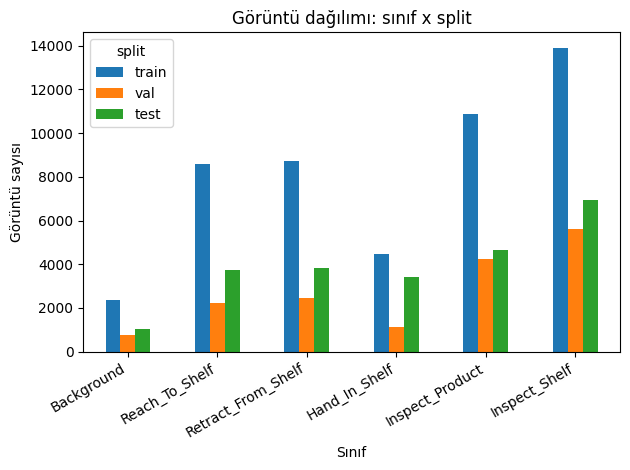


Örnek dosyalar (val/Inspect_Product):
 - /content/MERL_WORK_LOCAL/dataset_cls/val/Inspect_Product/21_1_crop_f000497.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/val/Inspect_Product/21_1_crop_f000499.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/val/Inspect_Product/21_1_crop_f000501.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/val/Inspect_Product/21_1_crop_f000503.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/val/Inspect_Product/21_1_crop_f000505.jpg

Örnek dosyalar (test/Background):
 - /content/MERL_WORK_LOCAL/dataset_cls/test/Background/27_1_crop_f000011.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/test/Background/27_1_crop_f000023.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/test/Background/27_1_crop_f000035.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/test/Background/27_1_crop_f000047.jpg
 - /content/MERL_WORK_LOCAL/dataset_cls/test/Background/27_1_crop_f000059.jpg


In [ ]:
# COUNT IMAGES PER SPLIT/CLASS + SAVE CSV TO DRIVE + QUICK PREVIEW
!pip -q install pandas matplotlib

import os, glob, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset kökü
DATASET_CLS = "/content/MERL_WORK_LOCAL/dataset_cls"

splits  = ["train", "val", "test"]
classes = ["Background","Reach_To_Shelf","Retract_From_Shelf","Hand_In_Shelf","Inspect_Product","Inspect_Shelf"]

# 1) Sayım
rows = []
for sp in splits:
    for cls in classes:
        n = 0
        for ext in ("*.jpg","*.jpeg","*.png"):
            n += len(glob.glob(os.path.join(DATASET_CLS, sp, cls, ext)))
        rows.append({"split": sp, "class": cls, "count": n})

df = pd.DataFrame(rows)
pt = df.pivot(index="class", columns="split", values="count").fillna(0).astype(int)
pt["total"] = pt.sum(axis=1)
totals_row = list(pt.sum(axis=0))
pt.loc["__TOTAL__"] = totals_row

print("\n=== Görsel Sayıları (class x split) ===")
display(pt)

# 2) Eksik sınıf uyarısı
for sp in splits:
    missing = [c for c in classes if pt.loc[c, sp] == 0]
    if missing:
        print(f"[UYARI] {sp} içinde görüntüsü olmayan sınıflar: {missing}")

# 3) CSV olarak Drive'a kaydet
OUT_DIR = "/content/drive/MyDrive/TURKCELL-CodeFem3/MERL_WORK_DRIVE/label_analysis"
os.makedirs(OUT_DIR, exist_ok=True)
ts = time.strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUT_DIR, f"split_image_counts_{ts}.csv")
pt.to_csv(csv_path)
print("\n[OK] CSV kaydedildi →", csv_path)

# 4) Hızlı görselleştirme (class x split bar chart)
plt.figure(figsize=(10,5))
pt.loc[classes, splits].plot(kind="bar")
plt.title("Görüntü dağılımı: sınıf x split")
plt.xlabel("Sınıf")
plt.ylabel("Görüntü sayısı")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# 5) Hızlı örnek dosya listesi (ilk 5)
def head_files(sp, cls, k=5):
    files = []
    for ext in ("*.jpg","*.jpeg","*.png"):
        files += glob.glob(os.path.join(DATASET_CLS, sp, cls, ext))
    return sorted(files)[:k]

print("\nÖrnek dosyalar (val/Inspect_Product):")
for p in head_files("val","Inspect_Product",5):
    print(" -", p)

print("\nÖrnek dosyalar (test/Background):")
for p in head_files("test","Background",5):
    print(" -", p)


# **TRAIN**

**TRAIN WITH THE DATASET FROM COLAB LOCAL (EARLY STOPPING)**

In [ ]:
# ============================
# TRAIN (LOCAL DATASET + EARLY STOP)
# ============================
!pip -q install ultralytics

import os, shutil, gc
from datetime import datetime

# Drive sadece çıktı kopyalamak için (best.pt vs.)
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception:
    drive.mount('/content/drive', force_remount=True)

# ---- Yollar ----
DATASET_CLS = "/content/MERL_WORK_LOCAL/dataset_cls"   # PREP (LOCAL) hücresinden gelen dataset
RUNS_LOCAL  = "/content/YOLOCLS_runs_local"            # Ultralytics runs/ (LOCAL)
OUT_DRIVE   = "/content/drive/MyDrive/TURKCELL-CodeFem3/Outputs_MERL_YOLOCLS"  # best.pt + sonuçlar
os.makedirs(RUNS_LOCAL, exist_ok=True)
os.makedirs(OUT_DRIVE,  exist_ok=True)

assert os.path.isdir(DATASET_CLS), "Dataset bulunamadı: /content/MERL_WORK_LOCAL/dataset_cls (Önce PREP (LOCAL) hücresini çalıştır.)"

# ---- Hiperparametreler ----
IMG_SIZE = 224      # bir tık daha iyi doğruluk için 224
BATCH    = 32       # GPU'na göre artır/azalt
WORKERS  = 2        # LOCAL disk hızlı -> 2 makul; OOM olursa 0 yap
EPOCHS   = 60
PATIENCE = 10       # <<< Erken durdurma AÇIK

from ultralytics import YOLO
import torch, glob

gc.collect()
try:
    torch.cuda.empty_cache()
except:
    pass

# ---- Model checkpoint fallback (12 -> 11 -> 8) ----
model = None
for ckpt in ["yolo12n-cls.pt","yolo11n-cls.pt","yolov8n-cls.pt"]:
    try:
        model = YOLO(ckpt)
        print("Using", ckpt)
        break
    except Exception as e:
        print("Cannot load", ckpt, "->", e)
assert model is not None

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"train_{ts}"

# ---- Eğitim ----
results = model.train(
    data=DATASET_CLS,   # root: train/ val/ test/ altında sınıf klasörleri
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    workers=WORKERS,
    cache=False,        # RAM şişirmesin
    patience=PATIENCE,  # <<< EarlyStopping ON
    amp=False,          # NaN/Inf riskini azalt
    lr0=5e-4,
    mixup=0.0,
    cutmix=0.0,
    optimizer='AdamW',
    seed=0,
    device=0,
    project=RUNS_LOCAL, # runs -> LOCAL
    name=run_name,
    verbose=True
)

# ---- En iyi ağırlıkları ve sonuç dosyalarını Drive'a kopyala ----
run_dir   = os.path.join(RUNS_LOCAL, run_name)
best_src  = os.path.join(run_dir, "weights", "best.pt")
last_src  = os.path.join(run_dir, "weights", "last.pt")
csv_src   = os.path.join(run_dir, "results.csv")  # Ultralytics sonuç CSV

best_dst  = os.path.join(OUT_DRIVE, f"best_from_train_{ts}.pt")
last_dst  = os.path.join(OUT_DRIVE, f"last_from_train_{ts}.pt")
csv_dst   = os.path.join(OUT_DRIVE, f"results_{ts}.csv")

if os.path.exists(best_src):
    shutil.copy2(best_src, best_dst)
    print("✓ BEST copied to Drive ->", best_dst)
else:
    print("! best.pt bulunamadı:", best_src)

if os.path.exists(last_src):
    shutil.copy2(last_src, last_dst)
    print("✓ LAST copied to Drive ->", last_dst)

if os.path.exists(csv_src):
    shutil.copy2(csv_src, csv_dst)
    print("✓ results.csv copied to Drive ->", csv_dst)

print("TRAIN bitti ✅  EarlyStopping =",
      PATIENCE, "| Çıkış klasörü (LOCAL):", run_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.6 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Cannot load yolo12n-cls.pt -> [Errno 2] No such file or directory: 'yolo12n-cls.pt'
Using yolo11n-cls.pt
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content

# **VALIDATION**

In [ ]:
# ============================
# VAL ONLY (LOCAL DATASET) — evaluate on val/
# ============================
!pip -q install ultralytics

import os, shutil, glob, gc
from datetime import datetime

# Dataset ve çıktı yolları
DATASET_CLS = "/content/MERL_WORK_LOCAL/dataset_cls"     # PREP (LOCAL)'den
RUNS_LOCAL  = "/content/YOLOCLS_runs_local"              # Ultralytics runs/ (LOCAL)
OUT_DRIVE   = "/content/drive/MyDrive/TURKCELL-CodeFem3/Outputs_MERL_YOLOCLS"  # rapor/figür kopyası
os.makedirs(RUNS_LOCAL, exist_ok=True)
os.makedirs(OUT_DRIVE,  exist_ok=True)

assert os.path.isdir(DATASET_CLS), "Dataset yok: /content/MERL_WORK_LOCAL/dataset_cls"

# Hiperparametreler (eğitimle uyumlu tut)
IMG_SIZE = 224
BATCH    = 32
WORKERS  = 2   # OOM olursa 0 yap

from ultralytics import YOLO
import torch, json
gc.collect()
try: torch.cuda.empty_cache()
except: pass

def _latest_train_best(runs_root):
    """En son train_* klasörünü bulup weights/best.pt döndürür."""
    if not os.path.isdir(runs_root):
        return None
    trains = sorted(
        [d for d in glob.glob(os.path.join(runs_root, "train_*")) if os.path.isdir(d)],
        key=lambda p: os.path.getmtime(p),
        reverse=True
    )
    for tdir in trains:
        cand = os.path.join(tdir, "weights", "best.pt")
        if os.path.exists(cand):
            return cand
    return None

def _latest_drive_best(out_drive):
    """Drive’daki Outputs_MERL_YOLOCLS altındaki en güncel best_from_train_*.pt’yi döndürür."""
    cands = sorted(
        glob.glob(os.path.join(out_drive, "best_from_train_*.pt")),
        key=lambda p: os.path.getmtime(p),
        reverse=True
    )
    return cands[0] if cands else None

# 1) Checkpoint seçimi: LOCAL -> DRIVE fallback
CKPT = _latest_train_best(RUNS_LOCAL)
if CKPT is None:
    CKPT = _latest_drive_best(OUT_DRIVE)
assert CKPT is not None, "Checkpoint bulunamadı! Önce TRAIN hücresini çalıştırın."

print("Using checkpoint:", CKPT)
model = YOLO(CKPT)

# 2) Val çalıştır
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
val_name = f"val_{ts}"

results = model.val(
    data=DATASET_CLS,      # kök klasör: train/ val/ test/ yapısı
    split='val',           # sadece val/
    imgsz=IMG_SIZE,
    batch=BATCH,
    workers=WORKERS,
    device=0,
    project=RUNS_LOCAL,    # sonuçlar LOCAL'e
    name=val_name,
    verbose=True
)

# 3) Metrix kısa özet (uyumlu olanı yakala)
top1 = top5 = None
try:
    # Ultralytics bazı versiyonlarda dict, bazılarında obj döndürebiliyor
    m = getattr(results, "metrics", None)
    if isinstance(m, dict):
        top1 = m.get("accuracy_top1", m.get("top1_acc", None))
        top5 = m.get("accuracy_top5", m.get("top5_acc", None))
    else:
        top1 = getattr(m, "accuracy_top1", getattr(m, "top1_acc", None))
        top5 = getattr(m, "accuracy_top5", getattr(m, "top5_acc", None))
except Exception:
    pass

print(f"\nVAL summary -> top1: {top1} | top5: {top5}")

# 4) Çıktıları Drive’a kopyala (val run klasöründeki faydalı dosyalar)
val_dir = os.path.join(RUNS_LOCAL, val_name)
assert os.path.isdir(val_dir), f"Val klasörü bulunamadı: {val_dir}"

VAL_OUT = os.path.join(OUT_DRIVE, f"VAL_{ts}")
os.makedirs(VAL_OUT, exist_ok=True)

# Yaygın dosyaları topla: csv/json/png/jpg
patterns = ["*.csv", "*.json", "*.png", "*.jpg", "*.jpeg", "*.txt"]
copied = []
for pat in patterns:
    for f in glob.glob(os.path.join(val_dir, pat)):
        try:
            shutil.copy2(f, os.path.join(VAL_OUT, os.path.basename(f)))
            copied.append(os.path.basename(f))
        except Exception as e:
            print("Copy skip:", f, "->", e)

# weights/best.pt de varsa (bazı sürümlerde val yeni beste çıkarmaz), bilgi için kopyala
w_best = os.path.join(val_dir, "weights", "best.pt")
if os.path.exists(w_best):
    shutil.copy2(w_best, os.path.join(VAL_OUT, f"best_from_val_{ts}.pt"))
    copied.append(f"best_from_val_{ts}.pt")

print("\nVAL tamam ✅")
print("Local run dir:", val_dir)
print("Drive export :", VAL_OUT)
print("Exported files:", copied)


Using checkpoint: /content/YOLOCLS_runs_local/train_20251014_174721/weights/best.pt
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11n-cls summary (fused): 47 layers, 1,533,710 parameters, 0 gradients, 3.2 GFLOPs
train: /content/MERL_WORK_LOCAL/dataset_cls/train... found 48939 images in 6 classes ✅ 
val: /content/MERL_WORK_LOCAL/dataset_cls/val... found 16441 images in 6 classes ✅ 
test: /content/MERL_WORK_LOCAL/dataset_cls/test... found 23577 images in 6 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2596.2±1444.2 MB/s, size: 122.2 KB)
val: Scanning /content/MERL_WORK_LOCAL/dataset_cls/val... 16441 images, 0 corrupt: 100% ━━━━━━━━━━━━ 16441/16441 28.0Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 514/514 6.3it/s 1:21
                   all      0.315      0.951
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/YOLOCLS_runs_local/val_2

# **TEST**

In [ ]:
# ============================
# TEST ONLY (LOCAL DATASET) — robust top1/top5 readout
# ============================
!pip -q install ultralytics

import os, shutil, glob, gc, json
from datetime import datetime

# Yollar
DATASET_CLS = "/content/MERL_WORK_LOCAL/dataset_cls"   # PREP (LOCAL) çıktısı
RUNS_LOCAL  = "/content/YOLOCLS_runs_local"            # Ultralytics runs/ (LOCAL)
OUT_DRIVE   = "/content/drive/MyDrive/TURKCELL-CodeFem3/Outputs_MERL_YOLOCLS"
os.makedirs(RUNS_LOCAL, exist_ok=True)
os.makedirs(OUT_DRIVE,  exist_ok=True)
assert os.path.isdir(os.path.join(DATASET_CLS, "test")), "Test split bulunamadı!"

# Hiperparametreler
IMG_SIZE = 224
BATCH    = 32
WORKERS  = 2

from ultralytics import YOLO
import torch
gc.collect()
try: torch.cuda.empty_cache()
except: pass

def _latest_train_best(runs_root):
    if not os.path.isdir(runs_root):
        return None
    trains = sorted(
        [d for d in glob.glob(os.path.join(runs_root, "train_*")) if os.path.isdir(d)],
        key=lambda p: os.path.getmtime(p),
        reverse=True
    )
    for tdir in trains:
        cand = os.path.join(tdir, "weights", "best.pt")
        if os.path.exists(cand):
            return cand
    return None

def _latest_drive_best(out_drive):
    cands = sorted(
        glob.glob(os.path.join(out_drive, "best_from_train_*.pt")),
        key=lambda p: os.path.getmtime(p),
        reverse=True
    )
    return cands[0] if cands else None

# En güncel best.pt
CKPT = _latest_train_best(RUNS_LOCAL) or _latest_drive_best(OUT_DRIVE)
assert CKPT is not None, "Checkpoint bulunamadı! Önce TRAIN hücresini çalıştırın."
print("Using checkpoint:", CKPT)

model = YOLO(CKPT)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
test_name = f"test_{ts}"

# Değerlendirme (TEST split)
res = model.val(
    data=DATASET_CLS,
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH,
    workers=WORKERS,
    device=0,
    project=RUNS_LOCAL,
    name=test_name,
    verbose=True
)

# ---- Robust metrik yakalama (sürüm bağımsız) ----
def _extract_metric(obj, candidates):
    for path in candidates:
        cur = obj
        ok = True
        for key in path:
            if isinstance(cur, dict):
                cur = cur.get(key, None)
            else:
                cur = getattr(cur, key, None)
            if cur is None:
                ok = False
                break
        if ok and cur is not None:
            try:
                return float(cur)
            except Exception:
                return cur
    return None

top1 = _extract_metric(
    res,
    [('metrics','top1'), ('metrics','top1_acc'), ('metrics','accuracy_top1'),
     ('top1',), ('top1_acc',), ('accuracy_top1',)]
)
top5 = _extract_metric(
    res,
    [('metrics','top5'), ('metrics','top5_acc'), ('metrics','accuracy_top5'),
     ('top5',), ('top5_acc',), ('accuracy_top5',)]
)

print(f"\nTEST summary (parsed) -> top1: {top1} | top5: {top5}")

# ---- Çıktıları Drive’a kopyala + metrikleri json olarak yaz ----
test_dir = os.path.join(RUNS_LOCAL, test_name)
TEST_OUT = os.path.join(OUT_DRIVE, f"TEST_{ts}")
os.makedirs(TEST_OUT, exist_ok=True)

# görseller/raporlar
for pat in ["*.csv", "*.json", "*.png", "*.jpg", "*.jpeg", "*.txt"]:
    for f in glob.glob(os.path.join(test_dir, pat)):
        try: shutil.copy2(f, os.path.join(TEST_OUT, os.path.basename(f)))
        except: pass

# metrik json
metrics_json = {"top1": top1, "top5": top5, "imgsz": IMG_SIZE, "batch": BATCH}
with open(os.path.join(test_dir, "metrics_manual.json"), "w") as f:
    json.dump(metrics_json, f, indent=2)
shutil.copy2(os.path.join(test_dir, "metrics_manual.json"),
             os.path.join(TEST_OUT, "metrics_manual.json"))

print("\nTEST tamam ✅")
print("Local run dir:", test_dir)
print("Drive export :", TEST_OUT)


Using checkpoint: /content/YOLOCLS_runs_local/train_20251014_174721/weights/best.pt
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11n-cls summary (fused): 47 layers, 1,533,710 parameters, 0 gradients, 3.2 GFLOPs
train: /content/MERL_WORK_LOCAL/dataset_cls/train... found 48939 images in 6 classes ✅ 
val: /content/MERL_WORK_LOCAL/dataset_cls/val... found 16441 images in 6 classes ✅ 
test: /content/MERL_WORK_LOCAL/dataset_cls/test... found 23577 images in 6 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2528.6±836.3 MB/s, size: 123.2 KB)
test: Scanning /content/MERL_WORK_LOCAL/dataset_cls/test... 23577 images, 0 corrupt: 100% ━━━━━━━━━━━━ 23577/23577 3.3Kit/s 7.2s
test: New cache created: /content/MERL_WORK_LOCAL/dataset_cls/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 737/737 6.3it/s 1:57
                   all      0.276      0.941
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0m

# **TEST MODEL WITH A .MP4 VİDEO FILE**

In [11]:
# ============================
# VIDEO INFERENCE (YOLO-CLS) — best.pt ile tek mp4 değerlendirme
# ============================
!pip -q install ultralytics pandas opencv-python

import os, gc, glob, json, math, shutil
from datetime import datetime
from collections import Counter, defaultdict

import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
import torch

# -------------------
# USER CONFIG
# -------------------
VIDEO_PATH   = "/content/40_1_crop.mp4" # <-- KENDİ MP4 YOLUNU YAZ
CKPT_PATH    = "/content/best.pt"       # <-- KENDİ MODEL YOLUNU YAZ
DRIVE_OUT    = "/content/drive/MyDrive/TURKCELL-CodeFem3/Video_Evals"  # Drive’a kopyalanacak yer

OUT_ROOT     = "/content"  # çıktıların kök klasörü
COPY_TO_DRIVE = True
IMG_SIZE     = 224        # eğitimle uyumlu
BATCH_INFER  = 64         # GPU'na göre artır/azalt
TARGET_FPS   = 15         # videodan örneklenecek efektif FPS (yaklaşık)
SMOOTH_WIN   = 5          # tekil kare flicker'ını azaltmak için çoğunluk filtresi (tek sayı; 1=kapalı)
WRITE_ANNOTATED = True    # anotasyonlu video kaydet
HALF         = False      # FP16 (destekleyen GPU’da hızlanabilir)

# -------------------
# checkpoint & model
# -------------------
assert CKPT_PATH and os.path.exists(CKPT_PATH), f"best.pt bulunamadı: {CKPT_PATH}"

device = 0 if torch.cuda.is_available() else "cpu"
model = YOLO(CKPT_PATH)
if HALF and device != "cpu":
    model.model.half()

print("Using checkpoint:", CKPT_PATH)
print("Device:", device)

# -------------------
# video okuma / örnekleme
# -------------------
assert os.path.exists(VIDEO_PATH), f"Video yok: {VIDEO_PATH}"
cap = cv2.VideoCapture(VIDEO_PATH)
src_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
src_w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
src_h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
src_n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
stride  = max(1, int(round(src_fps / TARGET_FPS)))
eff_fps = src_fps / stride
print(f"Video: {VIDEO_PATH} | fps_in={src_fps:.3f}, stride={stride} -> eff_fps≈{eff_fps:.3f}, frames={src_n}")

# -------------------
# çıktı klasörleri
# -------------------
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
EVAL_DIR = os.path.join(OUT_ROOT, f"VIDEO_EVAL_{ts}")
os.makedirs(EVAL_DIR, exist_ok=True)

CSV_FRAMES   = os.path.join(EVAL_DIR, "per_frame_predictions.csv")
CSV_SEGMENTS = os.path.join(EVAL_DIR, "segments.csv")
JSON_SUMMARY = os.path.join(EVAL_DIR, "summary.json")
VID_OUT      = os.path.join(EVAL_DIR, "annotated.mp4")

# -------------------
# renkler (sınıf id -> BGR)
# -------------------
def _color_for(i):
    # basit sabit palet
    palette = [
        (60,180,255), (80,220,100), (240,180,70),
        (200,120,255), (60,60,255), (60,255,255),
        (120,120,120), (180,180,60), (255,120,120),
    ]
    return palette[i % len(palette)]

# -------------------
# toplu (batch) inference
# -------------------
names = None
frame_idxs_src = []   # orijinal frame index (0-based)
times_sec      = []   # frame zamanı (s)
top1_ids       = []
top1_names     = []
top1_confs     = []
top5_list      = []   # [(id, name, conf), ...]

batch_imgs = []
batch_meta = []  # (src_idx, t_sec)

def run_batch():
    global batch_imgs, batch_meta, names
    if not batch_imgs:
        return
    preds = model.predict(
        batch_imgs,
        imgsz=IMG_SIZE,
        device=device,
        verbose=False
    )
    if names is None:
        # Ultralytics classification isimleri
        names = preds[0].names
    for pr, (src_idx, t_sec) in zip(preds, batch_meta):
        probs = pr.probs  # tensor
        # top-1
        tid = int(probs.top1)
        conf1 = float(probs.data[tid])
        tname = names.get(tid, str(tid)) if isinstance(names, dict) else (names[tid] if tid < len(names) else str(tid))
        # top-5
        t5_ids = list(map(int, probs.top5))
        t5 = []
        for k in t5_ids:
            nm = names.get(k, str(k)) if isinstance(names, dict) else (names[k] if k < len(names) else str(k))
            t5.append((k, nm, float(probs.data[k])))

        frame_idxs_src.append(src_idx)
        times_sec.append(t_sec)
        top1_ids.append(tid)
        top1_names.append(tname)
        top1_confs.append(conf1)
        top5_list.append(t5)

    batch_imgs = []
    batch_meta = []
    gc.collect()

# oku + örnekle
src_idx = -1
while True:
    ok, img = cap.read()
    if not ok:
        break
    src_idx += 1
    if (src_idx % stride) != 0:
        continue
    t_sec = src_idx / src_fps  # videonun gerçek zamanına göre
    batch_imgs.append(img)
    batch_meta.append((src_idx, t_sec))
    if len(batch_imgs) >= BATCH_INFER:
        run_batch()

run_batch()
cap.release()

assert len(top1_ids) > 0, "Hiç örnek frame çıkarılamadı; TARGET_FPS veya stride’ı kontrol et."

# -------------------
# opsiyonel temporal smoothing (çoğunluk)
# -------------------
def smooth_majority(ids, win):
    if win <= 1 or win % 2 == 0:
        return ids
    r = []
    half = win // 2
    n = len(ids)
    for i in range(n):
        s = max(0, i - half)
        e = min(n, i + half + 1)
        seg = ids[s:e]
        c = Counter(seg).most_common(1)[0][0]
        r.append(int(c))
    return r

ids_raw = list(top1_ids)
ids_smooth = smooth_majority(ids_raw, SMOOTH_WIN)
names_map = names if isinstance(names, dict) else {i:n for i,n in enumerate(names)}

# -------------------
# segmentlere (zaman aralığı) birleştir
# -------------------
segments = []  # dict: class_id, class_name, start_idx_src, end_idx_src, start_sec, end_sec, duration_sec
if ids_smooth:
    cur_id = ids_smooth[0]
    start_i = 0
    for i in range(1, len(ids_smooth)):
        if ids_smooth[i] != cur_id:
            st_src = frame_idxs_src[start_i]
            en_src = frame_idxs_src[i-1]
            st_t   = times_sec[start_i]
            en_t   = times_sec[i-1]
            segments.append({
                "class_id":   int(cur_id),
                "class_name": names_map.get(int(cur_id), str(cur_id)),
                "start_frame_src": int(st_src),
                "end_frame_src":   int(en_src),
                "start_sec":  float(st_t),
                "end_sec":    float(en_t),
                "duration_sec": float(max(0.0, en_t - st_t + (1.0/eff_fps)))  # yaklaşık
            })
            cur_id = ids_smooth[i]
            start_i = i
    # son segment
    st_src = frame_idxs_src[start_i]
    en_src = frame_idxs_src[len(ids_smooth)-1]
    st_t   = times_sec[start_i]
    en_t   = times_sec[len(ids_smooth)-1]
    segments.append({
        "class_id":   int(cur_id),
        "class_name": names_map.get(int(cur_id), str(cur_id)),
        "start_frame_src": int(st_src),
        "end_frame_src":   int(en_src),
        "start_sec":  float(st_t),
        "end_sec":    float(en_t),
        "duration_sec": float(max(0.0, en_t - st_t + (1.0/eff_fps)))
    })

# sınıf bazında özet
dur_by_cls = defaultdict(float)
count_by_cls = defaultdict(int)
for seg in segments:
    dur_by_cls[seg["class_name"]]  += seg["duration_sec"]
    count_by_cls[seg["class_name"]] += 1

# -------------------
# per-frame CSV
# -------------------
rows = []
for i in range(len(times_sec)):
    t5 = [{"id": k, "name": n, "conf": c} for (k,n,c) in top5_list[i]]
    rows.append({
        "frame_src": frame_idxs_src[i],
        "time_sec":  times_sec[i],
        "top1_id_raw": int(ids_raw[i]),
        "top1_name_raw": names_map.get(int(ids_raw[i]), str(ids_raw[i])),
        "top1_id_smooth": int(ids_smooth[i]),
        "top1_name_smooth": names_map.get(int(ids_smooth[i]), str(ids_smooth[i])),
        "top1_conf": float(top1_confs[i]),
        "top5": json.dumps(t5, ensure_ascii=False)
    })
pd.DataFrame(rows).to_csv(CSV_FRAMES, index=False)

# segment CSV
pd.DataFrame(segments).to_csv(CSV_SEGMENTS, index=False)

# summary JSON
summary = {
    "video_path": VIDEO_PATH,
    "checkpoint": CKPT_PATH,
    "img_size": IMG_SIZE,
    "target_fps": TARGET_FPS,
    "effective_fps": eff_fps,
    "stride": stride,
    "smoothing_window": SMOOTH_WIN,
    "classes": names_map,
    "per_class": {
        k: {"segments": int(count_by_cls[k]), "total_sec": float(dur_by_cls[k])}
        for k in sorted(dur_by_cls.keys())
    }
}
with open(JSON_SUMMARY, "w") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("Saved:")
print(" - per-frame CSV   :", CSV_FRAMES)
print(" - segments CSV    :", CSV_SEGMENTS)
print(" - summary JSON    :", JSON_SUMMARY)

# -------------------
# Anotasyonlu video (isteğe bağlı)
# -------------------
if WRITE_ANNOTATED:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(VID_OUT, fourcc, eff_fps, (src_w, src_h))
    for i in range(len(times_sec)):
        # yeniden görüntüyü inputtan okumak yerine hızlıca tekrar oku (örneklenen frame’i çekeceğiz)
        # Not: büyük videolarda ikinci okuma maliyetli olabilir; pratikte yeterli.
        cap = cv2.VideoCapture(VIDEO_PATH)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idxs_src[i])
        ok, frame = cap.read()
        cap.release()
        if not ok:
            continue
        cid = int(ids_smooth[i])
        cname = names_map.get(cid, str(cid))
        conf = top1_confs[i]
        tsec = times_sec[i]

        # üst sol etiket
        label = f"{cname}  {conf:.2f}  t={tsec:6.2f}s"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        cv2.rectangle(frame, (10, 10), (10+tw+10, 10+th+10), _color_for(cid), -1)
        cv2.putText(frame, label, (15, 10+th+2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2, cv2.LINE_AA)

        # alt zaman çizgisi
        progress = i / max(1, (len(times_sec)-1))
        bar_w = int(progress * src_w)
        cv2.rectangle(frame, (0, src_h-12), (bar_w, src_h), _color_for(cid), -1)

        out.write(frame)
    out.release()
    print(" - annotated video :", VID_OUT)

# -------------------
# Drive’a kopyala (opsiyonel)
# -------------------
if COPY_TO_DRIVE:
    os.makedirs(DRIVE_OUT, exist_ok=True)
    dst = os.path.join(DRIVE_OUT, os.path.basename(EVAL_DIR))
    if os.path.exists(dst):
        shutil.rmtree(dst, ignore_errors=True)
    shutil.copytree(EVAL_DIR, dst)
    print("Copied to Drive    :", dst)

print("\nÖZET (segment bazında):")
for cls in sorted(dur_by_cls.keys()):
    print(f" - {cls:18s} -> segments: {count_by_cls[cls]:3d}  total: {dur_by_cls[cls]:7.2f}s")


Using checkpoint: /content/best.pt
Device: 0
Video: /content/40_1_crop.mp4 | fps_in=30.000, stride=2 -> eff_fps≈15.000, frames=4020
Saved:
 - per-frame CSV   : /content/VIDEO_EVAL_20251015_111835/per_frame_predictions.csv
 - segments CSV    : /content/VIDEO_EVAL_20251015_111835/segments.csv
 - summary JSON    : /content/VIDEO_EVAL_20251015_111835/summary.json
 - annotated video : /content/VIDEO_EVAL_20251015_111835/annotated.mp4
Copied to Drive    : /content/drive/MyDrive/TURKCELL-CodeFem3/Video_Evals/VIDEO_EVAL_20251015_111835

ÖZET (segment bazında):
 - Hand_In_Shelf      -> segments:   6  total:    4.67s
 - Inspect_Product    -> segments:  18  total:    9.80s
 - Inspect_Shelf      -> segments:  25  total:  118.13s
 - Reach_To_Shelf     -> segments:   5  total:    0.93s
 - Retract_From_Shelf -> segments:   4  total:    0.47s


# **DOWNLOAD RESULTS FOLDER**

In [ ]:
# Zip (sessiz, rekürsif)
!zip -r -q /content/YOLOCLS_runs_local.zip /content/YOLOCLS_runs_local
from google.colab import files
files.download("/content/YOLOCLS_runs_local.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Zip (sessiz, rekürsif)
!zip -r -q /content/VIDEO_EVAL_20251015_111835.zip /content/VIDEO_EVAL_20251015_111835
from google.colab import files
files.download("/content/VIDEO_EVAL_20251015_111835.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>